In [88]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/changwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/changwei/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/changwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# data = pd.read_csv('10_CounterStrike.csv')    

In [292]:
# data = data[data['language']=='english']
# data = data.drop(columns=['recommendationid', 
#                    'timestamp_created', 
#                    'timestamp_updated',
#                    'steam_purchase',
#                   'received_for_free',
#                   'written_during_early_access',
#                   'author.steamid',
#                   'author.num_games_owned',
#                   'author.num_reviews',
#                   'author.last_played'])

In [83]:
def clean_reviews(reviews):
    reviews = reviews.str.replace("[^a-zA-Z#]", " ")
    reviews = reviews.astype(str)
    if len(reviews)>100:
        reviews = reviews.apply(lambda x: x if len(x.split())>20 else '')
        reviews = reviews.where(lambda x : x!='').dropna()
    reviews = reviews.apply(lambda x: ' '.join([w.lower() for w in x.split() if len(w)>2]))
    return reviews

In [84]:
# Keep noun
is_noun_or_adj = lambda pos: pos[:2]=='NN' or pos[:2]=='JJ'
lemmatizer = WordNetLemmatizer()

def noun_adj_processor(word, pos):
    if pos[:2] == 'NN':
        return lemmatizer.lemmatize(word)
    else:
        return lemmatizer.lemmatize(word, pos='a')

def keep_noun_and_adj(rev):
    return [noun_adj_processor(word, pos) for (word,pos) in nltk.pos_tag(rev) if is_noun_or_adj(pos)]

In [85]:
# Remove stop words
stop_words = stopwords.words('english')
stop_words.extend(['player', 'play', 'people', 'game', 'steam','review',
                  'day', 'year', 'hour', 'minute','time','moment',
                  'world', 'yes', 'lol', 'lmao', 'cool', 'love', 'get',
                  'good', 'great', 'nice', 'best', 'fun', 'awesome',
                   'ever', 'kinda', 'shit', 'yeah', 'new', 'old',
                  'big','small','high','low','many','much','lot',
                  'others','thank','http','thing','everyone','anyone','anything',
                  'everything','cant','dont','guy','hello',
                  'youtube','something','someone','pro','con',
                  'haha', 'hehe','end','nothing','no','one',
                  'fine','first','last','epic','english','bit',
                  'terrible','overall','original','life','bad',
                  'today','fps','gameplay','favorite','com',
                  'man','word','version','pure','experience','www',
                  'please','thanks','little','least','way','different',
                  'style','man','men','super','problem','item','work','computer',
                  'stuff','wait','early','access','sure','able','developer','wow','genre',
                  'potential','perfect','popular','reason','person'])
stop_words.extend(['server','update','performance','system','program','software'])
stop_words.extend(['worth','full','point','real','part','amount','reason',
                  'option','open','previous','huge','enjoyable','kind','ton',
                  'person','launch','opinion','month','ability','current','use',
                  'stupid','mess','slash','wololo','wrong'])

In [86]:
def remove_stopwords(rev):
    return [i for i in rev if i not in stop_words]

In [89]:
def process_review(review):
    r = review.split()
    r = keep_noun_and_adj(r)
    r = remove_stopwords(r)
    r = keep_noun_and_adj(r)
    r = remove_stopwords(r)
    return " ".join([i for i in r])

def get_info(reviews):
    num_reviews = len(reviews)
    if num_reviews == 0:
        return dict()
    
    print("clean reviews")
    reviews = clean_reviews(reviews)
    print(len(reviews))
    print("keep nouns and adj, remove stop words")
    reviews = [process_review(review) for review in reviews]
    
    print("create freq dict")
    # Create freq dict
    reviews = list(filter(None, reviews))
    reviews = [list(set(r.split())) for r in reviews]
    
    all_words = [w for r in reviews for w in r]
    freq_words = nltk.FreqDist(all_words)
    freq_words = dict(filter(lambda elem: elem[1]>1 and elem[0] not in stop_words, freq_words.items()))

    easy_count = 0
    hard_count = 0
    bug_count = 0
    
    easy_count += freq_words.pop('easy', 0)
    easy_count += freq_words.pop('simple', 0)
    hard_count += freq_words.pop('hard', 0)
    hard_count += freq_words.pop('difficult', 0)
    bug_count += freq_words.pop('bug', 0)
    bug_count += freq_words.pop('issue', 0)
    bug_count += freq_words.pop('crash', 0)
    
    easy_count /= num_reviews
    hard_count /= num_reviews
    bug_count /= num_reviews
    
    freq_words = sorted(freq_words.items(), key=lambda item:(item[1],item[0]), reverse=True)
    freq_words = freq_words[:50]
    
    if not freq_words:
        return dict()
    
    info = {'freq_words':freq_words, 'easy_count':easy_count, 'hard_count':hard_count, 'bug_count':bug_count}
    return info

# Dataset
## https://www.kaggle.com/smeeeow/steam-game-reviews

In [46]:
# Dataset: 
# https://www.kaggle.com/smeeeow/steam-game-reviews
directory = "/Users/viviancai/Downloads/game_rvw_csvs"
# directory = "/Users/viviancai/Desktop/cs4300/cs4300sp2021-cw887-qh75-rz92-yc687-yl698/data"
name_to_info = dict()
for file in os.listdir(directory):
    if file.endswith(".csv"):
        path = os.path.join(directory, file)
        data = pd.read_csv(path)    
        print(path)
        
        info = get_info(data['review'])
        if info:
            name_to_info[file] = info
        print(info)

with open(os.path.join(directory, 'name_to_dict.json'), 'w') as fp:
    json.dump(name_to_info, fp, indent=4)

/Users/viviancai/Downloads/game_rvw_csvs/49520_Borderlands2.csv
{'freq_words': [('borderland', 1952), ('story', 1882), ('friend', 1559), ('character', 1331), ('gun', 1246), ('shooter', 1201), ('dlc', 928), ('loot', 875), ('looter', 622), ('handsome', 620), ('sale', 611), ('graphic', 599), ('funny', 490), ('shoot', 478), ('content', 475), ('weapon', 472), ('humor', 452), ('series', 426), ('worth', 418), ('level', 412), ('enemy', 395), ('jack', 385), ('collection', 365), ('unique', 359), ('mission', 356), ('quest', 345), ('money', 303), ('main', 296), ('ton', 293), ('gud', 288), ('side', 287), ('point', 275), ('fantastic', 269), ('line', 268), ('classic', 264), ('rpg', 260), ('dlcs', 254), ('skill', 245), ('action', 236), ('price', 235), ('part', 230), ('amount', 230), ('free', 227), ('single', 225), ('enjoyable', 222), ('mechanic', 221), ('art', 219), ('sequel', 217), ('xbox', 215), ('multiplayer', 213)], 'easy_count': 0.013401639344262296, 'hard_count': 0.014262295081967214, 'bug_count

{'freq_words': [('toxic', 819), ('friend', 668), ('community', 653), ('shooter', 553), ('operator', 499), ('team', 417), ('ubisoft', 378), ('tactical', 375), ('gud', 364), ('siege', 353), ('competitive', 339), ('map', 303), ('hate', 261), ('match', 260), ('gun', 259), ('rainbow', 245), ('money', 239), ('curve', 225), ('hacker', 198), ('casual', 191), ('cheater', 185), ('graphic', 182), ('trash', 177), ('guess', 175), ('realistic', 174), ('skill', 171), ('season', 166), ('mechanic', 158), ('worth', 154), ('person', 153), ('level', 150), ('console', 150), ('full', 147), ('unique', 143), ('suck', 141), ('round', 140), ('reason', 138), ('wall', 137), ('character', 136), ('shoot', 135), ('sound', 134), ('fuck', 133), ('point', 128), ('toxicity', 127), ('strategy', 126), ('csgo', 123), ('enemy', 120), ('real', 119), ('teammate', 117), ('enjoyable', 116)], 'easy_count': 0.008153153153153153, 'hard_count': 0.016306306306306306, 'bug_count': 0.026396396396396397}
/Users/viviancai/Downloads/game

{'freq_words': [('manager', 23), ('touch', 20), ('football', 19), ('full', 18), ('team', 14), ('match', 12), ('real', 9), ('engine', 8), ('addictive', 8), ('tactic', 7), ('season', 7), ('money', 7), ('depth', 7), ('brilliant', 7), ('league', 6), ('improvement', 6), ('enough', 6), ('club', 6), ('top', 5), ('previous', 5), ('management', 5), ('feature', 5), ('enjoyable', 5), ('competition', 5), ('class', 5), ('series', 4), ('result', 4), ('reason', 4), ('quick', 4), ('press', 4), ('point', 4), ('part', 4), ('mode', 4), ('mobile', 4), ('injury', 4), ('excellent', 4), ('editor', 4), ('edition', 4), ('development', 4), ('detail', 4), ('classic', 4), ('championship', 4), ('wage', 3), ('tablet', 3), ('screen', 3), ('report', 3), ('release', 3), ('realistic', 3), ('main', 3), ('level', 3)], 'easy_count': 0.05426356589147287, 'hard_count': 0.007751937984496124, 'bug_count': 0.04263565891472868}
/Users/viviancai/Downloads/game_rvw_csvs/418460_RisingStorm2Vietnam.csv
{'freq_words': [('realistic',

{'freq_words': [('squad', 1561), ('team', 1452), ('realistic', 1027), ('shooter', 1025), ('map', 944), ('community', 758), ('graphic', 693), ('tank', 679), ('post', 595), ('communication', 591), ('war', 561), ('scriptum', 553), ('hell', 532), ('devs', 524), ('battlefield', 505), ('enemy', 497), ('teamwork', 485), ('gun', 485), ('tactical', 454), ('realism', 445), ('point', 433), ('sound', 410), ('full', 394), ('immersive', 393), ('battle', 387), ('wwii', 376), ('role', 370), ('commander', 366), ('friend', 363), ('real', 344), ('match', 335), ('feel', 332), ('shot', 331), ('mechanic', 331), ('combat', 329), ('leader', 305), ('mic', 296), ('action', 287), ('future', 264), ('part', 263), ('cod', 263), ('spawn', 262), ('fantastic', 262), ('class', 258), ('large', 255), ('red', 252), ('simulator', 246), ('vehicle', 243), ('orchestra', 236), ('optimization', 234)], 'easy_count': 0.032240387249977166, 'hard_count': 0.04064298109416385, 'bug_count': 0.10667640880445703}
/Users/viviancai/Downlo

{'freq_words': [('survival', 462), ('season', 320), ('devs', 291), ('village', 290), ('quest', 277), ('medieval', 277), ('building', 268), ('graphic', 234), ('future', 219), ('content', 179), ('dynasty', 172), ('food', 160), ('animal', 158), ('point', 157), ('house', 151), ('beautiful', 148), ('mechanic', 146), ('npc', 145), ('town', 141), ('money', 137), ('alpha', 136), ('option', 133), ('development', 133), ('villager', 127), ('short', 122), ('price', 117), ('skill', 115), ('resource', 115), ('real', 113), ('map', 110), ('kingdom', 106), ('tree', 104), ('release', 104), ('management', 102), ('kind', 100), ('idea', 99), ('state', 98), ('enjoyable', 97), ('current', 97), ('story', 96), ('person', 96), ('feature', 95), ('fix', 94), ('feel', 93), ('build', 93), ('character', 92), ('worth', 91), ('wife', 91), ('amount', 91), ('horse', 88)], 'easy_count': 0.06972730410769762, 'hard_count': 0.050396962374870555, 'bug_count': 0.21470486710390058}
/Users/viviancai/Downloads/game_rvw_csvs/4771

{'freq_words': [('car', 947), ('sim', 879), ('graphic', 559), ('physic', 512), ('track', 485), ('race', 472), ('sound', 356), ('wheel', 267), ('corsa', 253), ('feel', 244), ('multiplayer', 231), ('real', 224), ('simulator', 220), ('assetto', 214), ('acc', 210), ('release', 208), ('kunos', 198), ('online', 192), ('ffb', 191), ('realistic', 187), ('drive', 183), ('content', 183), ('full', 175), ('simulation', 174), ('rating', 173), ('mode', 163), ('feedback', 159), ('engine', 158), ('driver', 158), ('force', 156), ('single', 154), ('fantastic', 152), ('title', 147), ('series', 142), ('support', 135), ('setup', 133), ('racer', 133), ('career', 132), ('weather', 127), ('price', 124), ('night', 118), ('point', 117), ('top', 116), ('quality', 116), ('level', 116), ('control', 116), ('racing', 115), ('sims', 111), ('option', 108), ('money', 108)], 'easy_count': 0.03613053613053613, 'hard_count': 0.04195804195804196, 'bug_count': 0.09294871794871795}
/Users/viviancai/Downloads/game_rvw_csvs/38

{'freq_words': [('batman', 3821), ('story', 2974), ('arkham', 2495), ('series', 1755), ('batmobile', 1701), ('graphic', 1698), ('city', 1431), ('combat', 1262), ('mission', 920), ('riddler', 814), ('tank', 810), ('rocksteady', 776), ('side', 769), ('gtx', 756), ('port', 748), ('previous', 714), ('sale', 703), ('fan', 677), ('character', 675), ('main', 622), ('part', 613), ('dlc', 583), ('launch', 524), ('release', 521), ('mechanic', 476), ('point', 461), ('asylum', 457), ('bat', 455), ('ram', 452), ('frame', 442), ('gotham', 440), ('patch', 431), ('battle', 426), ('full', 424), ('fight', 421), ('car', 414), ('control', 407), ('joker', 404), ('worth', 402), ('feel', 400), ('money', 396), ('drop', 393), ('fantastic', 377), ('refund', 363), ('challenge', 362), ('playable', 358), ('trophy', 354), ('console', 353), ('open', 350), ('bos', 347)], 'easy_count': 0.02869028833739779, 'hard_count': 0.03342418591306843, 'bug_count': 0.18146607373404103}
/Users/viviancai/Downloads/game_rvw_csvs/115

{'freq_words': [('war', 4068), ('total', 3919), ('battle', 1335), ('kingdom', 1187), ('campaign', 1150), ('diplomacy', 1096), ('unit', 1043), ('series', 1029), ('character', 893), ('general', 850), ('faction', 825), ('warhammer', 764), ('romance', 733), ('army', 637), ('shogun', 633), ('strategy', 621), ('fan', 604), ('title', 601), ('mechanic', 560), ('map', 542), ('mode', 540), ('historical', 525), ('dlc', 525), ('graphic', 498), ('previous', 470), ('china', 460), ('rome', 434), ('history', 429), ('hero', 400), ('chinese', 397), ('dynasty', 370), ('story', 359), ('option', 355), ('warrior', 353), ('combat', 352), ('feel', 349), ('unique', 347), ('franchise', 336), ('money', 315), ('period', 313), ('beautiful', 306), ('turn', 296), ('feature', 285), ('point', 277), ('part', 277), ('date', 275), ('enemy', 268), ('duel', 264), ('full', 253), ('city', 252)], 'easy_count': 0.03577512776831346, 'hard_count': 0.04258943781942078, 'bug_count': 0.07459876266475388}
/Users/viviancai/Downloads/

{'freq_words': [('team', 530), ('mode', 394), ('car', 357), ('career', 236), ('race', 230), ('codemasters', 166), ('driver', 144), ('graphic', 134), ('track', 129), ('real', 126), ('improvement', 126), ('addition', 118), ('wheel', 105), ('feature', 105), ('fan', 105), ('previous', 92), ('series', 84), ('multiplayer', 84), ('season', 83), ('myteam', 79), ('realistic', 78), ('online', 77), ('money', 69), ('full', 68), ('feel', 68), ('sim', 67), ('option', 66), ('livery', 64), ('pa', 63), ('fantastic', 61), ('drive', 60), ('screen', 59), ('controller', 59), ('engine', 58), ('date', 56), ('second', 54), ('formula', 54), ('sound', 53), ('difficulty', 52), ('corner', 52), ('podium', 50), ('step', 49), ('point', 49), ('level', 49), ('upgrade', 48), ('price', 47), ('fast', 46), ('change', 46), ('casual', 46), ('control', 45)], 'easy_count': 0.023867173988239364, 'hard_count': 0.02282947077135939, 'bug_count': 0.09512279488066414}
/Users/viviancai/Downloads/game_rvw_csvs/508440_TotallyAccurateB

{'freq_words': [('battlefield', 236), ('punkbuster', 140), ('multiplayer', 106), ('campaign', 103), ('origin', 89), ('map', 65), ('full', 61), ('vehicle', 56), ('shooter', 55), ('graphic', 54), ('community', 52), ('reason', 51), ('sale', 49), ('modern', 47), ('weapon', 46), ('active', 46), ('money', 43), ('single', 42), ('cheat', 39), ('worth', 38), ('story', 38), ('gun', 37), ('team', 34), ('point', 34), ('tank', 33), ('series', 33), ('xbox', 32), ('mode', 32), ('install', 32), ('fix', 32), ('price', 31), ('dice', 31), ('classic', 31), ('match', 30), ('official', 28), ('level', 28), ('launch', 28), ('dlc', 28), ('large', 27), ('enemy', 27), ('console', 27), ('opinion', 26), ('alive', 26), ('premium', 24), ('decent', 24), ('base', 24), ('support', 23), ('friend', 23), ('content', 23), ('war', 22)], 'easy_count': 0.0216998191681736, 'hard_count': 0.02109704641350211, 'bug_count': 0.06630500301386377}
/Users/viviancai/Downloads/game_rvw_csvs/334230_TownofSalem.csv
{'freq_words': [('role'

{'freq_words': [('mount', 81), ('combat', 40), ('character', 35), ('chinese', 29), ('story', 27), ('blade', 27), ('quest', 25), ('mod', 25), ('translation', 22), ('skill', 22), ('price', 20), ('enemy', 20), ('battle', 20), ('map', 18), ('unique', 17), ('point', 17), ('main', 17), ('faction', 17), ('class', 17), ('language', 16), ('feel', 16), ('warrior', 15), ('patch', 15), ('army', 15), ('unit', 14), ('troop', 14), ('option', 14), ('mechanic', 14), ('diablo', 14), ('top', 13), ('dynasty', 13), ('content', 13), ('ability', 13), ('support', 12), ('open', 12), ('level', 12), ('full', 12), ('basic', 12), ('side', 11), ('control', 11), ('worth', 10), ('strategy', 10), ('similar', 10), ('rpg', 10), ('idea', 10), ('hero', 10), ('fan', 10), ('area', 10), ('strong', 9), ('fight', 9)], 'easy_count': 0.053824362606232294, 'hard_count': 0.056657223796033995, 'bug_count': 0.07932011331444759}
/Users/viviancai/Downloads/game_rvw_csvs/381210_DeadbyDaylight.csv
{'freq_words': [('killer', 16625), ('fr

{'freq_words': [('strike', 1749), ('counter', 1644), ('source', 1353), ('csgo', 1078), ('classic', 946), ('mod', 839), ('community', 838), ('gmod', 735), ('graphic', 682), ('shooter', 600), ('texture', 592), ('map', 544), ('gun', 473), ('global', 444), ('friend', 428), ('offensive', 384), ('c', 374), ('bot', 332), ('garry', 321), ('engine', 296), ('valve', 279), ('mode', 278), ('competitive', 276), ('zombie', 271), ('money', 271), ('skin', 260), ('surf', 259), ('worth', 253), ('multiplayer', 247), ('bhop', 243), ('person', 241), ('team', 237), ('reason', 237), ('weapon', 228), ('sale', 225), ('series', 222), ('free', 214), ('opinion', 210), ('online', 209), ('real', 206), ('gud', 189), ('skill', 185), ('hacker', 176), ('memory', 175), ('gamemodes', 173), ('school', 168), ('terrorist', 167), ('full', 165), ('gold', 164), ('duty', 164)], 'easy_count': 0.017942490010185694, 'hard_count': 0.010890856381728434, 'bug_count': 0.004230980177074356}
/Users/viviancai/Downloads/game_rvw_csvs/2118

/Users/viviancai/Downloads/game_rvw_csvs/1174180_RedDeadRedemption2.csv
{'freq_words': [('story', 6710), ('rockstar', 4012), ('online', 3608), ('graphic', 3061), ('horse', 1955), ('character', 1945), ('mission', 1924), ('dead', 1826), ('single', 1808), ('mode', 1615), ('red', 1556), ('money', 1529), ('beautiful', 1523), ('gta', 1430), ('open', 1381), ('rdr', 1148), ('cowboy', 1098), ('detail', 1010), ('redemption', 994), ('full', 978), ('worth', 955), ('masterpiece', 902), ('control', 867), ('content', 815), ('real', 811), ('side', 805), ('price', 784), ('main', 776), ('part', 775), ('multiplayer', 766), ('west', 763), ('fantastic', 763), ('port', 733), ('console', 710), ('point', 705), ('immersive', 699), ('fix', 695), ('friend', 680), ('launch', 670), ('reason', 666), ('western', 661), ('slow', 660), ('error', 657), ('screen', 646), ('wild', 638), ('feel', 628), ('ultra', 622), ('hacker', 611), ('sale', 606), ('arthur', 601)], 'easy_count': 0.018044254961419523, 'hard_count': 0.02137

{'freq_words': [('survival', 2782), ('dayz', 1713), ('devs', 1345), ('zombie', 1146), ('scum', 1106), ('friend', 1011), ('loot', 1001), ('content', 962), ('base', 877), ('map', 865), ('graphic', 743), ('mechanic', 699), ('character', 698), ('pvp', 678), ('point', 675), ('money', 635), ('gun', 609), ('full', 584), ('future', 541), ('single', 523), ('food', 522), ('building', 502), ('development', 491), ('release', 489), ('feature', 489), ('community', 486), ('worth', 479), ('real', 473), ('state', 459), ('current', 451), ('realistic', 448), ('huge', 439), ('lag', 433), ('open', 427), ('hacker', 425), ('metabolism', 419), ('team', 418), ('idea', 397), ('price', 394), ('robot', 384), ('combat', 381), ('vehicle', 380), ('simulator', 369), ('month', 364), ('area', 361), ('place', 360), ('patch', 360), ('fix', 360), ('weapon', 358), ('feel', 358)], 'easy_count': 0.03981574962140333, 'hard_count': 0.050416456335184254, 'bug_count': 0.14153205451792025}
/Users/viviancai/Downloads/game_rvw_csvs

{'freq_words': [('war', 1627), ('total', 1450), ('battle', 832), ('empire', 656), ('campaign', 632), ('strategy', 589), ('series', 404), ('unit', 396), ('map', 313), ('mod', 304), ('naval', 275), ('army', 256), ('history', 247), ('graphic', 247), ('nation', 233), ('faction', 228), ('darthmod', 220), ('combat', 216), ('line', 202), ('period', 196), ('grand', 185), ('enemy', 184), ('napoleon', 183), ('real', 182), ('fan', 163), ('american', 163), ('money', 156), ('turn', 152), ('land', 147), ('rome', 146), ('troop', 144), ('ship', 144), ('trade', 141), ('country', 140), ('europe', 139), ('rts', 137), ('medieval', 136), ('era', 133), ('cannon', 133), ('title', 132), ('huge', 132), ('historical', 131), ('century', 131), ('large', 130), ('shogun', 128), ('part', 122), ('india', 122), ('general', 122), ('sale', 120), ('america', 118)], 'easy_count': 0.0315625, 'hard_count': 0.02671875, 'bug_count': 0.08015625}
/Users/viviancai/Downloads/game_rvw_csvs/359320_EliteDangerous.csv
{'freq_words': 

{'freq_words': [('isaac', 3600), ('rebirth', 2027), ('character', 1775), ('content', 1666), ('dlc', 1441), ('replayability', 1418), ('enemy', 1411), ('room', 1374), ('rogue', 1349), ('value', 1311), ('afterbirth', 1243), ('challenge', 1198), ('bos', 1162), ('worth', 1105), ('graphic', 1020), ('amount', 1019), ('ton', 998), ('addictive', 981), ('run', 978), ('replay', 959), ('poop', 923), ('story', 919), ('mom', 908), ('dungeon', 890), ('achievement', 869), ('money', 853), ('mod', 837), ('level', 822), ('music', 796), ('endless', 773), ('synergy', 760), ('tear', 748), ('combination', 748), ('fantastic', 702), ('floor', 679), ('dark', 667), ('god', 639), ('roguelike', 638), ('unique', 634), ('difficulty', 612), ('price', 606), ('basement', 592), ('hell', 585), ('soundtrack', 570), ('mother', 553), ('random', 552), ('art', 540), ('secret', 522), ('mechanic', 510), ('heart', 509)], 'easy_count': 0.035556886739976895, 'hard_count': 0.05305720765050704, 'bug_count': 0.013927517008258098}
/Us

{'freq_words': [('skyrim', 4714), ('mod', 4093), ('graphic', 1280), ('story', 1233), ('quest', 1095), ('edition', 1020), ('rpg', 1015), ('open', 957), ('bethesda', 955), ('special', 918), ('elder', 873), ('character', 703), ('dragon', 669), ('community', 646), ('scroll', 639), ('classic', 566), ('dlc', 561), ('money', 524), ('main', 517), ('content', 507), ('xbox', 492), ('worth', 475), ('console', 469), ('creation', 447), ('beautiful', 438), ('free', 433), ('sale', 401), ('club', 394), ('reason', 375), ('side', 368), ('glitch', 359), ('line', 353), ('combat', 342), ('vanilla', 335), ('amount', 332), ('adventure', 331), ('release', 319), ('immersive', 319), ('fantasy', 318), ('todd', 309), ('oblivion', 305), ('fantastic', 291), ('point', 289), ('part', 282), ('full', 279), ('gud', 272), ('ton', 262), ('single', 256), ('endless', 255), ('series', 254)], 'easy_count': 0.016234088279054388, 'hard_count': 0.010018184823937841, 'bug_count': 0.04721441560588527}
/Users/viviancai/Downloads/ga

/Users/viviancai/Downloads/game_rvw_csvs/220200_KerbalSpaceProgram.csv
{'freq_words': [('space', 10713), ('rocket', 6497), ('mod', 3568), ('physic', 3191), ('science', 2925), ('kerbal', 2534), ('planet', 2347), ('ksp', 2056), ('part', 1998), ('orbit', 1972), ('community', 1917), ('moon', 1883), ('sandbox', 1837), ('kerbals', 1814), ('mun', 1747), ('mechanic', 1708), ('mission', 1639), ('orbital', 1635), ('ship', 1619), ('mode', 1544), ('simulator', 1511), ('curve', 1419), ('real', 1357), ('launch', 1235), ('plane', 1220), ('realistic', 1210), ('tutorial', 1168), ('career', 1159), ('station', 1050), ('solar', 1050), ('worth', 1001), ('money', 1000), ('flight', 967), ('explosion', 959), ('green', 918), ('fuel', 918), ('exploration', 898), ('simulation', 863), ('eula', 826), ('fantastic', 824), ('design', 796), ('basic', 796), ('building', 762), ('build', 762), ('full', 712), ('challenge', 712), ('engine', 704), ('point', 678), ('video', 659), ('craft', 658)], 'easy_count': 0.043996581042

/Users/viviancai/Downloads/game_rvw_csvs/227300_EuroTruckSimulator2.csv
{'freq_words': [('truck', 10365), ('simulator', 5682), ('graphic', 2661), ('mod', 2586), ('drive', 2498), ('road', 2452), ('real', 2126), ('realistic', 2111), ('wheel', 2016), ('dlc', 1839), ('multiplayer', 1712), ('simulation', 1697), ('money', 1636), ('euro', 1598), ('driver', 1560), ('map', 1557), ('europe', 1538), ('radio', 1506), ('job', 1499), ('ets', 1303), ('sim', 1183), ('company', 1167), ('car', 1158), ('music', 1138), ('sale', 1112), ('city', 1014), ('traffic', 963), ('friend', 961), ('chill', 880), ('country', 876), ('addictive', 870), ('community', 864), ('trailer', 854), ('trucker', 843), ('beautiful', 816), ('trucking', 799), ('worth', 791), ('sc', 790), ('enjoyable', 740), ('price', 730), ('cargo', 729), ('scenery', 712), ('relax', 678), ('american', 670), ('content', 655), ('full', 650), ('part', 649), ('speed', 641), ('fantastic', 622), ('station', 620)], 'easy_count': 0.023890850109722354, 'hard_

{'freq_words': [('diablo', 6109), ('arpg', 3213), ('grim', 2878), ('class', 2866), ('quest', 2836), ('dawn', 2786), ('character', 2779), ('story', 2088), ('titan', 2079), ('skill', 1961), ('loot', 1541), ('level', 1335), ('build', 1294), ('path', 1253), ('graphic', 1226), ('content', 1158), ('fan', 1108), ('point', 1079), ('exile', 1070), ('rpg', 1017), ('expansion', 912), ('poe', 876), ('hack', 869), ('action', 867), ('dark', 835), ('devotion', 834), ('slash', 813), ('difficulty', 811), ('worth', 799), ('feel', 789), ('combat', 782), ('option', 777), ('price', 767), ('customization', 751), ('enemy', 747), ('dungeon', 693), ('type', 690), ('arpgs', 683), ('ton', 680), ('ability', 678), ('area', 673), ('sale', 667), ('full', 663), ('dlc', 663), ('mechanic', 662), ('map', 654), ('friend', 631), ('combination', 616), ('choice', 613), ('monster', 610)], 'easy_count': 0.053336604514229634, 'hard_count': 0.041462217860647695, 'bug_count': 0.04823356231599608}
/Users/viviancai/Downloads/game_

{'freq_words': [('character', 2290), ('pathfinder', 2147), ('story', 2051), ('rpg', 1466), ('difficulty', 1386), ('kingdom', 1363), ('combat', 1274), ('gate', 1153), ('party', 1085), ('quest', 1045), ('level', 1000), ('baldur', 940), ('management', 920), ('option', 883), ('mechanic', 851), ('crpg', 843), ('choice', 809), ('class', 772), ('point', 748), ('rule', 716), ('companion', 709), ('real', 683), ('kingmaker', 654), ('part', 637), ('encounter', 629), ('tabletop', 621), ('main', 591), ('fan', 587), ('enemy', 586), ('pillar', 582), ('feel', 544), ('normal', 526), ('devs', 517), ('fight', 514), ('screen', 507), ('map', 501), ('patch', 496), ('spell', 489), ('top', 466), ('graphic', 463), ('eternity', 449), ('turn', 439), ('amount', 437), ('ability', 424), ('rpgs', 423), ('divinity', 422), ('mod', 419), ('kind', 415), ('release', 409), ('design', 409)], 'easy_count': 0.09171597633136094, 'hard_count': 0.1496196111580727, 'bug_count': 0.349323753169907}
/Users/viviancai/Downloads/game_

{'freq_words': [('story', 1817), ('kojima', 857), ('simulator', 721), ('delivery', 643), ('death', 629), ('graphic', 538), ('unique', 479), ('beautiful', 473), ('character', 416), ('mechanic', 358), ('hideo', 358), ('music', 349), ('point', 340), ('part', 305), ('action', 288), ('package', 286), ('weird', 265), ('masterpiece', 258), ('kind', 245), ('main', 243), ('movie', 234), ('slow', 232), ('real', 232), ('combat', 221), ('worth', 214), ('video', 214), ('scene', 214), ('fantastic', 213), ('vehicle', 212), ('full', 210), ('cargo', 210), ('feel', 209), ('cutscenes', 207), ('open', 205), ('soundtrack', 200), ('port', 194), ('sense', 192), ('road', 183), ('journey', 179), ('type', 174), ('idea', 171), ('whole', 170), ('sam', 167), ('mission', 167), ('metal', 166), ('plot', 160), ('area', 158), ('structure', 157), ('norman', 156), ('solid', 155)], 'easy_count': 0.047770219198790626, 'hard_count': 0.05200302343159486, 'bug_count': 0.05729402872260015}
/Users/viviancai/Downloads/game_rvw_c

/Users/viviancai/Downloads/game_rvw_csvs/582010_MonsterHunterWorld.csv
{'freq_words': [('monster', 14242), ('hunter', 8075), ('friend', 5467), ('weapon', 4348), ('series', 3252), ('story', 3074), ('graphic', 3012), ('multiplayer', 2750), ('hunt', 2559), ('content', 2516), ('combat', 2325), ('connection', 2207), ('capcom', 2071), ('iceborne', 1983), ('quest', 1969), ('port', 1884), ('armor', 1872), ('console', 1806), ('fight', 1726), ('mechanic', 1712), ('control', 1662), ('online', 1641), ('part', 1622), ('worth', 1520), ('grind', 1446), ('solo', 1399), ('character', 1387), ('point', 1327), ('fan', 1312), ('beautiful', 1303), ('previous', 1298), ('feel', 1289), ('controller', 1278), ('release', 1189), ('mhw', 1146), ('franchise', 1139), ('main', 1125), ('single', 1103), ('title', 1102), ('dlc', 1099), ('mission', 1096), ('quality', 1090), ('fantastic', 1079), ('full', 1062), ('amount', 1059), ('money', 1055), ('type', 1045), ('design', 1035), ('free', 1025), ('option', 1016)], 'easy_co

In [65]:
def combine_dicts(a, b):
    return {k: a.get(k, 0) + b.get(k, 0) for k in set(a)|set(b)}

all_freq_words = None

for (name, info) in name_to_info.items():
    freq_words = dict(info['freq_words'])
    freq_words = {x:1 for x in freq_words.keys()}
    if all_freq_words is None:
        all_freq_words = freq_words
    else:
        all_freq_words = combine_dicts(all_freq_words, freq_words)

all_freq_words = dict(filter(lambda elem: elem[1]>1 and elem[0] not in stop_words, all_freq_words.items()))
all_freq_words = sorted(all_freq_words.items(), key=lambda item:(item[1],item[0]), reverse=True)

with open(os.path.join(directory, 'all_freq_words.json'), 'w') as fp:
    json.dump(all_freq_words, fp, indent=4)

# Dataset:
### https://www.kaggle.com/najzeko/steam-reviews-2021

In [2]:
file_directory = "/Users/changwei/Documents/GitHub/4300_datasets/steam_reviews.csv"

In [67]:
# columns we wish to keep/filter on
cols_to_keep = ['language', 'app_id', 'app_name', 'review', 'steam_purchase', 'author.num_reviews',
               'author.playtime_at_review']
# setup dataframe iterator, the ‘usecols’ parameter filters the columns in the csv
dfs = [] # this list will store the filtered dataframes for concatenation
for df in pd.read_csv(file_directory, chunksize=20000, usecols=cols_to_keep):
    temp_df = df[df['language'] == 'english'].rename(columns={'steam_purchase':'purchase',
                                                             'author.num_reviews':'num_reviews',
                                                             'author.playtime_at_review':'playtime'})
    temp_df.dropna(subset=['num_reviews', 'playtime', 'review'], inplace=True)
    print(temp_df.head(1))
    dfs += [temp_df.copy()]
# combine filtered dfs into large output df
concat_df = pd.concat(dfs)
df = concat_df

   app_id                  app_name language  \
3  292030  The Witcher 3: Wild Hunt  english   

                                              review  purchase  num_reviews  \
3  One of the best RPG's of all time, worthy of a...      True            3   

   playtime  
3    5524.0  
       app_id                  app_name language              review  \
20002  292030  The Witcher 3: Wild Hunt  english  this game s great.   

       purchase  num_reviews  playtime  
20002      True            4     427.0  
       app_id                  app_name language  \
40001  292030  The Witcher 3: Wild Hunt  english   

                                           review  purchase  num_reviews  \
40001  it sucks you in, a truly all time classic.      True            2   

       playtime  
40001    9560.0  
       app_id                  app_name language  \
60004  292030  The Witcher 3: Wild Hunt  english   

                                                  review  purchase  \
60004  The best game

        app_id                  app_name language  \
660000     420  Half-Life 2: Episode Two  english   

                                                   review  purchase  \
660000  Episode 2 of the Half-Life franchise following...      True   

        num_reviews  playtime  
660000           31     735.0  
        app_id  app_name language                               review  \
680000     620  Portal 2  english  Is good but my brain hurts a little   

        purchase  num_reviews  playtime  
680000      True           75     581.0  
        app_id  app_name language  \
700000     620  Portal 2  english   

                                                   review  purchase  \
700000  To be honest, this is one of the best games i ...      True   

        num_reviews  playtime  
700000            1    1322.0  
        app_id  app_name language  \
720000     620  Portal 2  english   

                                                   review  purchase  \
720000  This game was AMA

         app_id     app_name language                  review  purchase  \
1400002    4000  Garry's Mod  english  Gud m8s. Wud gmod agan      True   

         num_reviews  playtime  
1400002            3    1233.0  
         app_id     app_name language  \
1420001    4000  Garry's Mod  english   

                                                    review  purchase  \
1420001  The best sandbox game I've played. This is a g...      True   

         num_reviews  playtime  
1420001            1    4065.0  
         app_id     app_name language  \
1440000    4000  Garry's Mod  english   

                                                    review  purchase  \
1440000  This is fun when it works, but it tends to be ...      True   

         num_reviews  playtime  
1440000            3     584.0  
         app_id     app_name language  \
1460000    4000  Garry's Mod  english   

                                                    review  purchase  \
1460000  Hundreds of usermade gamemodes 

         app_id          app_name language  \
2060001  381210  Dead by Daylight  english   

                                                    review  purchase  \
2060001  This is a great game with intense moments and ...      True   

         num_reviews  playtime  
2060001            3     321.0  
         app_id          app_name language                review  purchase  \
2080001  381210  Dead by Daylight  english  Best with frinds! :)      True   

         num_reviews  playtime  
2080001            2    1235.0  
         app_id          app_name language  \
2100001  381210  Dead by Daylight  english   

                                                    review  purchase  \
2100001  I'm Changing my review to a positive one. Sinc...      True   

         num_reviews  playtime  
2100001            8   65010.0  
         app_id          app_name language  \
2120003  381210  Dead by Daylight  english   

                                                    review  purchase  \
2120

         app_id app_name language     review  purchase  num_reviews  playtime
2680003  504230  Celeste  english  wonderful      True            7     496.0
         app_id                            app_name language  \
2700002  240720  Getting Over It with Bennett Foddy  english   

                                                    review  purchase  \
2700002  I remember first playing this game when it fir...      True   

         num_reviews  playtime  
2700002            7    3583.0  
         app_id                            app_name language  \
2720000  240720  Getting Over It with Bennett Foddy  english   

                                                    review  purchase  \
2720000  This game is pretty fun, especially once you g...      True   

         num_reviews  playtime  
2720000            1     651.0  
         app_id       app_name language  \
2740000  253230  A Hat in Time  english   

                                                    review  purchase  \
27400

         app_id                       app_name language review  purchase  \
3380001  250900  The Binding of Isaac: Rebirth  english   Good      True   

         num_reviews  playtime  
3380001            1     755.0  
         app_id                       app_name language  \
3400000  250900  The Binding of Isaac: Rebirth  english   

                                                    review  purchase  \
3400000  No matter how much it keeps hurting me... I ke...      True   

         num_reviews  playtime  
3400000           16   29636.0  
         app_id                       app_name language            review  \
3420001  250900  The Binding of Isaac: Rebirth  english  Win Streak: -900   

         purchase  num_reviews  playtime  
3420001      True           11     465.0  
         app_id     app_name language                    review  purchase  \
3440005  206440  To the Moon  english  A beautiful little game.      True   

         num_reviews  playtime  
3440005            3  

         app_id        app_name language  \
4080001  646570  Slay the Spire  english   

                                                    review  purchase  \
4080001  This game has been a true labor of love it see...      True   

         num_reviews  playtime  
4080001            4    3113.0  
         app_id                app_name language  \
4100000  227300  Euro Truck Simulator 2  english   

                                                    review  purchase  \
4100000  This is one of those relaxing and fun games wh...      True   

         num_reviews  playtime  
4100000            4    3935.0  
         app_id                app_name language          review  purchase  \
4120001  227300  Euro Truck Simulator 2  english  truck go vroom     False   

         num_reviews  playtime  
4120001            1     405.0  
         app_id                app_name language                    review  \
4140002  227300  Euro Truck Simulator 2  english  Boi this game is e p i c   

    

         app_id          app_name language  \
4700000  431960  Wallpaper Engine  english   

                                                    review  purchase  \
4700000  Useful for increasing the personality of your ...      True   

         num_reviews  playtime  
4700000            6    1590.0  
         app_id          app_name language  \
4720000  431960  Wallpaper Engine  english   

                                                   review  purchase  \
4720000  Love this! I'm always looking for new wallpapers      True   

         num_reviews  playtime  
4720000           19     243.0  
         app_id          app_name language  \
4740006  431960  Wallpaper Engine  english   

                                                    review  purchase  \
4740006  [b]WHERE THE FUCK HAS THIS PROGRAM BEEN WHEN I...      True   

         num_reviews  playtime  
4740006           19     149.0  
         app_id          app_name language  \
4760000  431960  Wallpaper Engine  english  

         app_id app_name language                        review  purchase  \
5300000  629760  MORDHAU  english  Khrone recommends this game!      True   

         num_reviews  playtime  
5300000            4    8864.0  
         app_id app_name language  \
5320000  629760  MORDHAU  english   

                                                    review  purchase  \
5320000  I am actually neutral about this game. Its fun...      True   

         num_reviews  playtime  
5320000            3     454.0  
         app_id app_name language  \
5340000  629760  MORDHAU  english   

                                                    review  purchase  \
5340000  Please add Japanese weapons and Armor, it woul...      True   

         num_reviews  playtime  
5340000           12    2327.0  
         app_id      app_name language  \
5360000  782330  DOOM Eternal  english   

                                                    review  purchase  \
5360000  I have played doom eternal for 9.5 hours 

         app_id                        app_name language review  purchase  \
5920006  359550  Tom Clancy's Rainbow Six Siege  english   Nice      True   

         num_reviews  playtime  
5920006            1     254.0  
         app_id                        app_name language         review  \
5940000  359550  Tom Clancy's Rainbow Six Siege  english  gun go brrrrr   

         purchase  num_reviews  playtime  
5940000      True            2    1492.0  
         app_id                        app_name language  \
5960000  359550  Tom Clancy's Rainbow Six Siege  english   

                       review  purchase  num_reviews  playtime  
5960000  really fun would buy      True            6     747.0  
         app_id                        app_name language  \
5980000  359550  Tom Clancy's Rainbow Six Siege  english   

                                         review  purchase  num_reviews  \
5980000  fun tsctical game to play with friends      True            1   

         playtime  
5

         app_id                        app_name language  \
6580004  359550  Tom Clancy's Rainbow Six Siege  english   

                                                    review  purchase  \
6580004  This game is really nice if you want a strateg...      True   

         num_reviews  playtime  
6580004            2    2696.0  
         app_id                        app_name language  \
6600000  359550  Tom Clancy's Rainbow Six Siege  english   

                           review  purchase  num_reviews  playtime  
6600000  spent so much time on it      True            3   12264.0  
         app_id                        app_name language review  purchase  \
6620003  359550  Tom Clancy's Rainbow Six Siege  english    hmm      True   

         num_reviews  playtime  
6620003           11   57664.0  
         app_id                        app_name language  \
6640002  359550  Tom Clancy's Rainbow Six Siege  english   

                                                    review  purchas

         app_id app_name language  \
7300000  252490     Rust  english   

                                                    review  purchase  \
7300000  Great game, its very popular right now because...      True   

         num_reviews  playtime  
7300000           13    3624.0  
         app_id app_name language  \
7320001  252490     Rust  english   

                                                    review  purchase  \
7320001  When i was like younger i thought this game wa...      True   

         num_reviews  playtime  
7320001            2      17.0  
         app_id app_name language                           review  purchase  \
7340000  252490     Rust  english  gun shot noises in the distance      True   

         num_reviews  playtime  
7340000           12     784.0  
         app_id app_name language            review  purchase  num_reviews  \
7360004  252490     Rust  english  I love this game     False            1   

         playtime  
7360004     614.0  
    

         app_id app_name language  \
7980003  648800     Raft  english   

                                                    review  purchase  \
7980003  Grate game loads of fun i would definitely rec...     False   

         num_reviews  playtime  
7980003            1    3406.0  
         app_id app_name language review  purchase  num_reviews  playtime
8000001  648800     Raft  english    Yes      True            2     422.0
         app_id app_name language  \
8020000  648800     Raft  english   

                                                    review  purchase  \
8020000  This review is based on playing for about 7 hr...      True   

         num_reviews  playtime  
8020000            2     624.0  
         app_id   app_name language  \
8040000  863550  HITMAN™ 2  english   

                                                    review  purchase  \
8040000  You need to be really patient while playing th...      True   

         num_reviews  playtime  
8040000           10   

         app_id                app_name language                       review  \
8640000   48700  Mount & Blade: Warband  english  Anatolia's only achievement   

         purchase  num_reviews  playtime  
8640000      True          155    2375.0  
         app_id                app_name language  \
8660001   48700  Mount & Blade: Warband  english   

                                                    review  purchase  \
8660001  One of the best if not the best game I've ever...      True   

         num_reviews  playtime  
8660001            7   10124.0  
         app_id                app_name language review  purchase  \
8680001   48700  Mount & Blade: Warband  english    yes      True   

         num_reviews  playtime  
8680001           14     650.0  
         app_id                app_name language  \
8700000   48700  Mount & Blade: Warband  english   

                                                    review  purchase  \
8700000  This game is amazing and so are all of the o

         app_id     app_name language  \
9280001  203160  Tomb Raider  english   

                                                    review  purchase  \
9280001  Tomb Raider has the polish and technical fines...      True   

         num_reviews  playtime  
9280001          176     789.0  
         app_id     app_name language    review  purchase  num_reviews  \
9300000  203160  Tomb Raider  english  Stunning     False            2   

         playtime  
9300000    2946.0  
         app_id     app_name language  \
9320000  203160  Tomb Raider  english   

                                                    review  purchase  \
9320000  \tYour adventure into the life of Lara Croft i...      True   

         num_reviews  playtime  
9320000            3     689.0  
         app_id app_name language       review  purchase  num_reviews  \
9340003  644560   Mirror  english  I lost chat     False            4   

         playtime  
9340003     137.0  
         app_id app_name language  \

         app_id       app_name language      review  purchase  num_reviews  \
9960000  252950  Rocket League  english  it is sick      True            1   

         playtime  
9960000   30068.0  
         app_id       app_name language  \
9980000  252950  Rocket League  english   

                                                    review  purchase  \
9980000  You can really sink in some money with the loo...      True   

         num_reviews  playtime  
9980000            9   34182.0  
          app_id       app_name language  \
10000002  252950  Rocket League  english   

                                                     review  purchase  \
10000002  It's all fun and games until it's you versus y...      True   

          num_reviews  playtime  
10000002           12   33888.0  
          app_id       app_name language  \
10020003  252950  Rocket League  english   

                                                     review  purchase  \
10020003  20€ and you get totoal shit t

          app_id                  app_name language  \
10580004  435150  Divinity: Original Sin 2  english   

                                                     review  purchase  \
10580004  A fantastically written (in both senses of the...      True   

          num_reviews  playtime  
10580004           11   12485.0  
          app_id                  app_name language  \
10600001  435150  Divinity: Original Sin 2  english   

                                                     review  purchase  \
10600001  Likely one of the best CRPGs made in the past ...      True   

          num_reviews  playtime  
10600001            1    7966.0  
          app_id                  app_name language  \
10620000  435150  Divinity: Original Sin 2  english   

                                                     review  purchase  \
10620000  tldr: got to bang the elf 10/10\n\non  a serio...     False   

          num_reviews  playtime  
10620000            1    3532.0  
          app_id      

          app_id                     app_name language           review  \
11160001   72850  The Elder Scrolls V: Skyrim  english  Truely Awesome!   

          purchase  num_reviews  playtime  
11160001     False           45    3686.0  
          app_id                     app_name language  \
11180000   72850  The Elder Scrolls V: Skyrim  english   

                                                     review  purchase  \
11180000  there is a big selection of mods  and if you d...     False   

          num_reviews  playtime  
11180000            1     987.0  
          app_id                     app_name language        review  \
11200000   72850  The Elder Scrolls V: Skyrim  english  For the mods   

          purchase  num_reviews  playtime  
11200000      True           11   32370.0  
          app_id                     app_name language  \
11220000   72850  The Elder Scrolls V: Skyrim  english   

                                                     review  purchase  \
112200

          app_id                  app_name language  \
11780000  270880  American Truck Simulator  english   

                                        review  purchase  num_reviews  \
11780000  very easy game to figure fun to play      True            1   

          playtime  
11780000     252.0  
          app_id                  app_name language  \
11800001  270880  American Truck Simulator  english   

                                                  review  purchase  \
11800001  Great game if you like driving and simulation.      True   

          num_reviews  playtime  
11800001            2    1126.0  
          app_id                  app_name language  \
11820000  270880  American Truck Simulator  english   

                                                     review  purchase  \
11820000  Really Good Game I Quality Textures I Really E...      True   

          num_reviews  playtime  
11820000            3     534.0  
          app_id               app_name language  \
11

          app_id app_name language  \
12360001  379720     DOOM  english   

                                                     review  purchase  \
12360001  A great action packed FPS. It was a tad shorte...      True   

          num_reviews  playtime  
12360001           27     836.0  
          app_id app_name language  \
12380000  379720     DOOM  english   

                                                     review  purchase  \
12380000  Don't tell me i can't stand the pain!\nTHIS WI...      True   

          num_reviews  playtime  
12380000           14    1231.0  
          app_id app_name language                review  purchase  \
12400000  379720     DOOM  english  Two words. Grab it !     False   

          num_reviews  playtime  
12400000           10    2038.0  
          app_id app_name language  \
12420004  379720     DOOM  english   

                                                     review  purchase  \
12420004  I don't have as much playtime as I'd like befo.

          app_id            app_name language               review  purchase  \
12980002  271590  Grand Theft Auto V  english  Comment is loading.      True   

          num_reviews  playtime  
12980002            3    7532.0  
          app_id            app_name language  \
13000000  271590  Grand Theft Auto V  english   

                                                     review  purchase  \
13000000   I mean for gosh sake it's GTA do even need to...      True   

          num_reviews  playtime  
13000000            3    2844.0  
          app_id            app_name language  \
13020012  271590  Grand Theft Auto V  english   

                                                     review  purchase  \
13020012  is fun with friends missions heists make some ...      True   

          num_reviews  playtime  
13020012            5   25721.0  
          app_id            app_name language review  purchase  num_reviews  \
13040009  271590  Grand Theft Auto V  english      o      True  

          app_id            app_name language     review  purchase  \
13580003  271590  Grand Theft Auto V  english  cool game      True   

          num_reviews  playtime  
13580003            1    2498.0  
          app_id            app_name language  \
13600000  271590  Grand Theft Auto V  english   

                                                     review  purchase  \
13600000  This game is good but they ban you for no reas...      True   

          num_reviews  playtime  
13600000            1    2523.0  
          app_id            app_name language  \
13620001  271590  Grand Theft Auto V  english   

                                                     review  purchase  \
13620001  takes big balls to slap your community in the ...      True   

          num_reviews  playtime  
13620001           19    2383.0  
          app_id            app_name language  \
13640000  271590  Grand Theft Auto V  english   

                                               review  purchase 

          app_id                       app_name language  \
14180006  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                        review  purchase  num_reviews  \
14180006  MERT EGY SZAR.TELE CHEATER G*****KEL     False            1   

          playtime  
14180006    4156.0  
          app_id                       app_name language  \
14200001  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                                     review  purchase  \
14200001  time consuming, frustrating, not fun unless yo...      True   

          num_reviews  playtime  
14200001            1   32832.0  
          app_id                       app_name language review  purchase  \
14220013  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   nice     False   

          num_reviews  playtime  
14220013            1   38734.0  
          app_id                       app_name language  \
14240007  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

          

          app_id                       app_name language  \
14780006  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                                     review  purchase  \
14780006  THIS GAME COULD'VE BEEN BETTER IF THEY JUST RE...      True   

          num_reviews  playtime  
14780006            2   19682.0  
          app_id                       app_name language  \
14800003  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                                     review  purchase  \
14800003  体验最差的游戏 没有之一！游戏开发者  已经 不是 那个落魄并且知道感恩的的乞丐了！他现在享...      True   

          num_reviews  playtime  
14800003            1   23213.0  
          app_id                       app_name language  \
14820003  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                 review  purchase  num_reviews  playtime  
14820003  cheaters, cheaters everywhere      True            4    9965.0  
          app_id                       app_name language 

          app_id                       app_name language  \
15360000  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                         review  purchase  num_reviews  playtime  
15360000  I'm a snake follow me     False            1     837.0  
          app_id                       app_name language  \
15380003  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english   

                                                     review  purchase  \
15380003  [h1] A Game That Should Still Be In Early Acce...      True   

          num_reviews  playtime  
15380003           53   20353.0  
          app_id                       app_name language          review  \
15400002  578080  PLAYERUNKNOWN'S BATTLEGROUNDS  english  shroud>PB>H1Z1   

          purchase  num_reviews  playtime  
15400002      True            6    7118.0  
          app_id               app_name language  \
15420009  582010  Monster Hunter: World  english   

                                  review  purchase  num_reviews

          app_id          app_name language          review  purchase  \
15980001  255710  Cities: Skylines  english  *really* great      True   

          num_reviews  playtime  
15980001            1   34784.0  
          app_id          app_name language  \
16000000  255710  Cities: Skylines  english   

                                                     review  purchase  \
16000000  Best city building game ever, finally i can pl...     False   

          num_reviews  playtime  
16000000            7    2822.0  
          app_id          app_name language  \
16020000  255710  Cities: Skylines  english   

                                                     review  purchase  \
16020000  Like City-Sim games? This is arguably the best...      True   

          num_reviews  playtime  
16020000            2    2552.0  
          app_id                  app_name language  \
16040004  582160  Assassin's Creed Origins  english   

                                        review  purcha

          app_id               app_name language  \
16600000  346110  ARK: Survival Evolved  english   

                                                     review  purchase  \
16600000  Fix your damn game before asking for such a hi...      True   

          num_reviews  playtime  
16600000            4   49404.0  
          app_id               app_name language   review  purchase  \
16620001  346110  ARK: Survival Evolved  english  not bad     False   

          num_reviews  playtime  
16620001            2     366.0  
          app_id               app_name language  \
16640000  346110  ARK: Survival Evolved  english   

                                                     review  purchase  \
16640000  If making the game even more draining by havin...      True   

          num_reviews  playtime  
16640000            2  276580.0  
          app_id               app_name language  \
16660000  346110  ARK: Survival Evolved  english   

                                            

          app_id   app_name language                    review  purchase  \
17220000  377160  Fallout 4  english  War....war never changes     False   

          num_reviews  playtime  
17220000           14    3286.0  
          app_id   app_name language  \
17240000  377160  Fallout 4  english   

                                                     review  purchase  \
17240000  My main issue is with the story and Roleplayin...      True   

          num_reviews  playtime  
17240000            6    3757.0  
          app_id   app_name language                            review  \
17260001  377160  Fallout 4  english  A bad game with a few good bits.   

          purchase  num_reviews  playtime  
17260001      True           27    3205.0  
          app_id   app_name language                            review  \
17280000  377160  Fallout 4  english  This is the best game of 2015!!!   

          purchase  num_reviews  playtime  
17280000     False           31    1616.0  
         

          app_id      app_name language  \
17820001  447040  Watch_Dogs 2  english   

                                                     review  purchase  \
17820001  Great game but when i try to launch it now a e...      True   

          num_reviews  playtime  
17820001            1    2353.0  
          app_id      app_name language  \
17840001  447040  Watch_Dogs 2  english   

                                                     review  purchase  \
17840001  Skip the first game of the series and buy this...     False   

          num_reviews  playtime  
17840001            8    1379.0  
          app_id                          app_name language  \
17860001  560130  Pillars of Eternity II: Deadfire  english   

                                                     review  purchase  \
17860001  Pros:\nBetter gameplay mechanics and graphics ...      True   

          num_reviews  playtime  
17860001           14    3625.0  
          app_id           app_name language  \
178800

          app_id  app_name language  \
18400002  105600  Terraria  english   

                                                     review  purchase  \
18400002  "Maybe I've played too much!"\n\nNot possible,...      True   

          num_reviews  playtime  
18400002            5    8052.0  
          app_id  app_name language  \
18420002  105600  Terraria  english   

                                                     review  purchase  \
18420002  Amazing game progression, great gameplay. Need...      True   

          num_reviews  playtime  
18420002            9   15599.0  
          app_id  app_name language  \
18440000  105600  Terraria  english   

                                                     review  purchase  \
18440000  A majority of this time it's been just running...     False   

          num_reviews  playtime  
18440000            2    1158.0  
          app_id  app_name language  \
18460001  105600  Terraria  english   

                                       

          app_id  app_name language review  purchase  num_reviews  playtime
19100001  218620  PAYDAY 2  english   Cool      True            7    4507.0
          app_id  app_name language review  purchase  num_reviews  playtime
19120001  218620  PAYDAY 2  english  noice      True            4     726.0
          app_id  app_name language   review  purchase  num_reviews  playtime
19140002  218620  PAYDAY 2  english  Нормуль      True           18     485.0
          app_id  app_name language  \
19160000  218620  PAYDAY 2  english   

                                                     review  purchase  \
19160000  cant understand why people like this game, it ...      True   

          num_reviews  playtime  
19160000           18     249.0  
          app_id  app_name language  \
19180001  218620  PAYDAY 2  english   

                                                     review  purchase  \
19180001  This game is fun but heavily relies on a weird...     False   

          num_review

          app_id        app_name language  \
19740001  594650  Hunt: Showdown  english   

                                                     review  purchase  \
19740001  Let me start off by saying it's a very aesthet...      True   

          num_reviews  playtime  
19740001            1    9614.0  
          app_id        app_name language  \
19760000  594650  Hunt: Showdown  english   

                                                     review  purchase  \
19760000  Can't recommend a game that I can't play due t...      True   

          num_reviews  playtime  
19760000           14      70.0  
          app_id                      app_name language     review  purchase  \
19780000  518790  theHunter: Call of the Wild™  english  relaxante      True   

          num_reviews  playtime  
19780000            1     778.0  
          app_id                      app_name language  \
19800007  518790  theHunter: Call of the Wild™  english   

                                review  

          app_id       app_name language review  purchase  num_reviews  \
20300000  613100  House Flipper  english  goodd      True            4   

          playtime  
20300000     431.0  
          app_id       app_name language  \
20320000  613100  House Flipper  english   

                                                     review  purchase  \
20320000  this game isnt overwhelmingly bad, but dont ju...      True   

          num_reviews  playtime  
20320000            8      48.0  
          app_id        app_name language  \
20340002  464920  Surviving Mars  english   

                                                     review  purchase  \
20340002  It's a great game with a lot of potential, but...      True   

          num_reviews  playtime  
20340002            6    2023.0  
          app_id   app_name language review  purchase  num_reviews  playtime
20360001  304390  For Honor  english   good     False           11    8863.0
          app_id   app_name language         

          app_id                      app_name language  \
20940000  673880  Warhammer 40,000: Mechanicus  english   

                                                     review  purchase  \
20940000  An excellent game.  The atmosphere and theming...      True   

          num_reviews  playtime  
20940000           28     666.0  
          app_id        app_name language  \
20960003  606280  Darksiders III  english   

                                                     review  purchase  \
20960003  I love Darksouls, and I love Darksiders..... I...     False   

          num_reviews  playtime  
20960003            8    2326.0  
          app_id            app_name language  \
20980002  701160  Kingdom Two Crowns  english   

                                                     review  purchase  \
20980002  Solid game to just chill and play, with alot o...      True   

          num_reviews  playtime  
20980002            2    2333.0  
          app_id      app_name language  \
210

          app_id       app_name language  \
21600001  367520  Hollow Knight  english   

                                                     review  purchase  \
21600001  10/10 this and or Ori are like what Michael Ja...      True   

          num_reviews  playtime  
21600001            2    3268.0  
          app_id       app_name language  \
21620001  447820  Day of Infamy  english   

                                             review  purchase  num_reviews  \
21620001  What's this Call of Duty people speak of?     False            6   

          playtime  
21620001     585.0  
          app_id          app_name language  \
21640001  512900  Streets of Rogue  english   

                                                     review  purchase  \
21640001  A great way to kill a couple of hours. easy to...     False   

          num_reviews  playtime  
21640001            9     760.0  
          app_id    app_name language  \
21660000  269950  X-Plane 11  english   

               

In [68]:
# select the dataframe for four games for further analysis and etc
Game_id = ['292030', '578080', '447040', '271590']
Game_name = ['Witcher III', 'PUBG', 'Watch Dogs II', 'GTA V']
selected_df = []
grouped_df = df.groupby(df.app_id)

In [76]:
for i in range(len(Game_id)):
    temp_df = grouped_df.get_group(int(Game_id[i]))
    selected_df.append(temp_df.copy())

### Analyzing the factor "number of reviews" (of the author)

In [134]:
# looking into the distribution of authors' number of reviews, seeing the relationship between
# average distinct word count vs. review numbers from the author

def numReviews_distribution(one_df, idx):
    numArray = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    numRev = np.array(one_df.num_reviews.values)
    revStr = one_df.review.values
    revDistWord = np.array(
        [np.unique(x.lower().split()).shape[0] for x in revStr])
    print('Game: ', Game_name[idx])
    for i in range(len(numArray)):
        if i != len(numArray)-1:
            tmp = revDistWord[(numRev > numArray[i]) &
                              (numRev <= numArray[i+1])]
            count = np.mean(tmp)
            count_review = tmp.shape[0]
            print('{} authors with in total {} to {} reviews have the average distinct word count of {}'.format(count_review,
                                                                                                                numArray[i],
                                                                                                                numArray[i+1],
                                                                                                                count))
        else:
            tmp = revDistWord[numRev > numArray[i]]
            count = np.mean(tmp)
            count_review = tmp.shape[0]
            print('{} authors with more than {} reviews have the average distinct word count of {}'.format(count_review,
                                                                                                           numArray[i],
                                                                                                           count))
    print()


def numReviews_dist(one_df):
    def output(ret, n):
        for i in range(n):
            print('author with {:.0f} to {:.0f} reviews: {}'.format(
                ret[1][i], ret[1][i+1], ret[0][i]))

    plt.figure()
    ret = plt.hist(one_df.num_reviews.values, bins=120)
    plt.xlabel('number of reviews from the author')
    plt.ylabel('number of authors/reviews')
    plt.show()
    output(ret, 5)

def numReview_viewer(i):
    print('Game: ', Game_name[i])
    numReviews_dist(selected_df[i])
    print()

Game:  Witcher III
110833 authors with in total 0 to 10 reviews have the average distinct word count of 22.92714263802297
20972 authors with in total 10 to 20 reviews have the average distinct word count of 33.39185580774366
8097 authors with in total 20 to 30 reviews have the average distinct word count of 38.34864764727677
3965 authors with in total 30 to 40 reviews have the average distinct word count of 43.670870113493066
2193 authors with in total 40 to 50 reviews have the average distinct word count of 47.087551299589606
1437 authors with in total 50 to 60 reviews have the average distinct word count of 49.45998608211552
902 authors with in total 60 to 70 reviews have the average distinct word count of 56.073170731707314
566 authors with in total 70 to 80 reviews have the average distinct word count of 59.36749116607774
435 authors with in total 80 to 90 reviews have the average distinct word count of 56.85057471264368
351 authors with in total 90 to 100 reviews have the average 

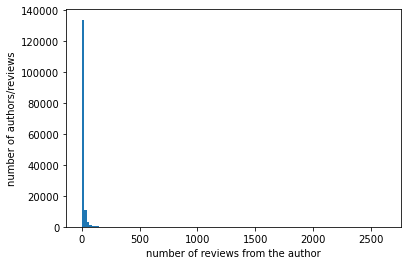

author with 1 to 23 reviews: 133986.0
author with 23 to 45 reviews: 10886.0
author with 45 to 67 reviews: 3219.0
author with 67 to 89 reviews: 1243.0
author with 89 to 110 reviews: 680.0

Game:  PUBG


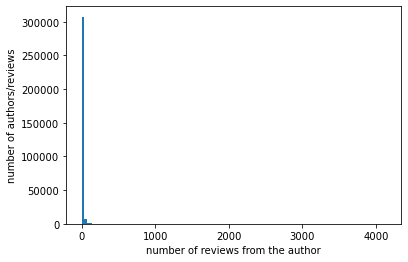

author with 1 to 35 reviews: 307388.0
author with 35 to 70 reviews: 7383.0
author with 70 to 104 reviews: 1629.0
author with 104 to 139 reviews: 556.0
author with 139 to 173 reviews: 244.0

Game:  Watch Dogs II


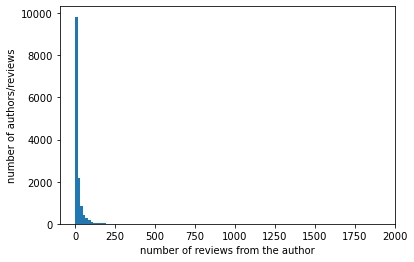

author with 1 to 17 reviews: 9832.0
author with 17 to 33 reviews: 2177.0
author with 33 to 49 reviews: 848.0
author with 49 to 64 reviews: 399.0
author with 64 to 80 reviews: 255.0

Game:  GTA V


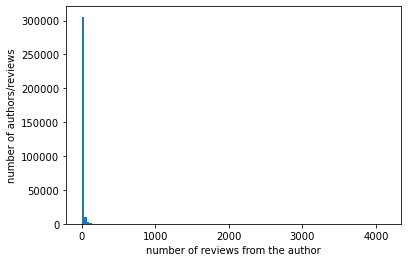

author with 1 to 35 reviews: 305673.0
author with 35 to 70 reviews: 9310.0
author with 70 to 104 reviews: 2209.0
author with 104 to 139 reviews: 760.0
author with 139 to 173 reviews: 355.0



In [135]:
# Analyzing the number of reviews factor for the arbitrarily selected 4 games
for i in range(len(Game_id)):
    numReviews_distribution(selected_df[i], i)

for i in range(len(Game_id)):
    numReview_viewer(i)

# There is a strong indication that author written more reviews will in average have more content-rich review
# 10 reviews in total for the author seems to be a breakpoint that there are still enough amount of reviews after filtering

### Analysis of the factor "Playtime"

In [138]:
# looking into the distribution of authors' playtime, seeing the relationship between
# average distinct word count vs. playtime of the author

def playtime_distribution(one_df, idx):
    numArray = [1000*x for x in list(range(11))]
    playtime = np.array(one_df.playtime.values)
    revStr = one_df.review.values
    revDistWord = np.array(
        [np.unique(x.lower().split()).shape[0] for x in revStr])
    print('Game: ', Game_name[idx])
    for i in range(len(numArray)):
        if i != len(numArray)-1:
            tmp = revDistWord[(playtime > numArray[i]) &
                              (playtime <= numArray[i+1])]
            count = np.mean(tmp)
            count_review = tmp.shape[0]
            print('{} authors with in total {} to {} playtime have the average distinct word count of {}'.format(count_review,
                                                                                                                numArray[i],
                                                                                                                numArray[i+1],
                                                                                                                count))
        else:
            tmp = revDistWord[playtime > numArray[i]]
            count = np.mean(tmp)
            count_review = tmp.shape[0]
            print('{} authors with more than {} playtime have the average distinct word count of {}'.format(count_review,
                                                                                                           numArray[i],
                                                                                                           count))
    print()
    
# looking into the distribution of authors' playtime
def playtime_dist(one_df):
    def output(ret, n):
        for i in range(n):
            print('author with {:.0f} to {:.0f} playtime: {}'.format(ret[1][i], ret[1][i+1], ret[0][i]))
                  
    plt.figure()
    ret = plt.hist(one_df.playtime.values, bins=150)
    plt.xlabel('playtime of the author')
    plt.ylabel('counts of author')
    plt.show()
    output(ret, 5)

def playtime_viewer(i):
    print('Game: ', Game_name[i])
    playtime_dist(selected_df[i])
    print()

Game:  Witcher III
27786 authors with in total 0 to 1000 playtime have the average distinct word count of 19.82030518966386
16080 authors with in total 1000 to 2000 playtime have the average distinct word count of 22.852922885572138
14589 authors with in total 2000 to 3000 playtime have the average distinct word count of 24.388854616491876
13439 authors with in total 3000 to 4000 playtime have the average distinct word count of 26.514398392737554
12475 authors with in total 4000 to 5000 playtime have the average distinct word count of 29.10132264529058
10835 authors with in total 5000 to 6000 playtime have the average distinct word count of 29.990216889709277
9770 authors with in total 6000 to 7000 playtime have the average distinct word count of 30.862026612077788
8054 authors with in total 7000 to 8000 playtime have the average distinct word count of 31.943506332257265
6692 authors with in total 8000 to 9000 playtime have the average distinct word count of 32.94231918708906
5622 auth

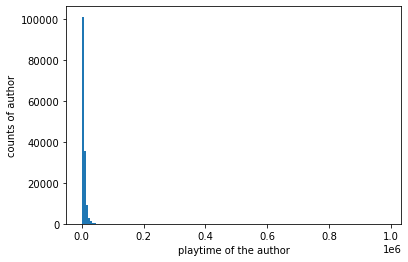

author with 1 to 6561 playtime: 100984.0
author with 6561 to 13120 playtime: 35576.0
author with 13120 to 19680 playtime: 9050.0
author with 19680 to 26240 playtime: 2946.0
author with 26240 to 32800 playtime: 1221.0

Game:  PUBG


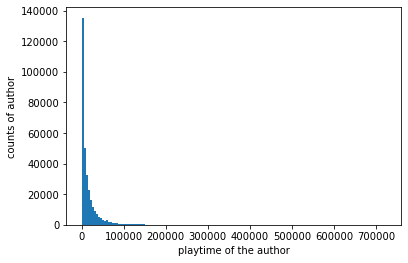

author with 1 to 4826 playtime: 135325.0
author with 4826 to 9651 playtime: 50069.0
author with 9651 to 14476 playtime: 32706.0
author with 14476 to 19302 playtime: 22685.0
author with 19302 to 24127 playtime: 16040.0

Game:  Watch Dogs II


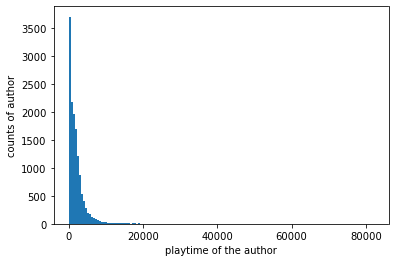

author with 1 to 548 playtime: 3709.0
author with 548 to 1094 playtime: 2179.0
author with 1094 to 1641 playtime: 1960.0
author with 1641 to 2187 playtime: 1700.0
author with 2187 to 2734 playtime: 1215.0

Game:  GTA V


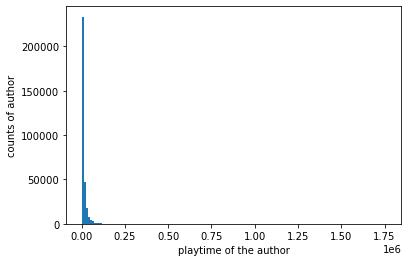

author with 1 to 11727 playtime: 233584.0
author with 11727 to 23452 playtime: 47035.0
author with 23452 to 35178 playtime: 17873.0
author with 35178 to 46903 playtime: 8168.0
author with 46903 to 58629 playtime: 4149.0



In [139]:
# Analyzing the playtime factor for the arbitrarily selected 4 games

for i in range(len(Game_id)):
    playtime_distribution(selected_df[i], i)

for i in range(len(Game_id)):
    playtime_viewer(i)


# small indication that author with more playtime will have more content-rich one generally
# a threshold of playtime=1000 seems to be a breakpoint

In [37]:
# Process reviews
app_id_to_name = dict()
for app_id in df.app_id.unique():
    name = df.loc[df['app_id'] == app_id, 'app_name'].iloc[0]
    app_id_to_name[app_id] = name

315


In [91]:
app_id_to_info = dict()
for app_id in app_id_to_name.keys():
    reviews = df.loc[df['app_id'] == app_id]['review']
    info = get_info(reviews)
    app_id_to_info[app_id] = info
    print(info)

clean reviews
50957
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 23361), ('character', 10585), ('quest', 10178), ('combat', 9095), ('graphic', 9024), ('witcher', 8940), ('rpg', 8777), ('main', 6959), ('side', 6882), ('dlc', 5550), ('beautiful', 5075), ('choice', 4161), ('geralt', 3971), ('content', 3958), ('monster', 3719), ('series', 3564), ('gwent', 3067), ('masterpiece', 2948), ('book', 2875), ('level', 2849), ('fantastic', 2832), ('hunt', 2826), ('money', 2736), ('sale', 2691), ('expansion', 2672), ('single', 2592), ('price', 2562), ('feel', 2503), ('line', 2476), ('second', 2439), ('wild', 2436), ('music', 2425), ('blood', 2423), ('detail', 2411), ('storyline', 2380), ('rpgs', 2375), ('difficulty', 2357), ('skyrim', 2340), ('mechanic', 2339), ('immersive', 2301), ('voice', 2283), ('dlcs', 2117), ('rich', 2083), ('whole', 2034), ('horse', 2008), ('amazing', 2000), ('action', 1982), ('wine', 1972), ('fantasy', 1945), ('fan', 1940)], 'easy_count': 

clean reviews
50584
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('killer', 21871), ('survivor', 15812), ('friend', 12892), ('community', 6459), ('perk', 6382), ('match', 5704), ('devs', 5307), ('dead', 4988), ('horror', 4909), ('toxic', 4807), ('rank', 4489), ('character', 4151), ('map', 3681), ('money', 3551), ('daylight', 3431), ('lobby', 3410), ('team', 3400), ('dlc', 3158), ('generator', 3111), ('hook', 2957), ('side', 2893), ('level', 2802), ('balance', 2626), ('free', 2605), ('content', 2422), ('skill', 2408), ('mechanic', 2294), ('fix', 2224), ('main', 2065), ('idea', 1991), ('chance', 1901), ('graphic', 1894), ('unique', 1861), ('sale', 1824), ('group', 1790), ('scary', 1762), ('escape', 1749), ('second', 1737), ('multiplayer', 1733), ('change', 1706), ('dbd', 1705), ('concept', 1668), ('price', 1625), ('patch', 1569), ('pallet', 1537), ('fact', 1463), ('single', 1446), ('due', 1432), ('glitch', 1416), ('job', 1407)], 'easy_count': 0.02923160263355279

5316
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('control', 872), ('mountain', 610), ('mouse', 565), ('foddy', 542), ('hammer', 507), ('top', 451), ('challenge', 451), ('bennett', 439), ('progress', 438), ('rage', 437), ('obstacle', 281), ('frustration', 268), ('second', 251), ('difficulty', 242), ('movement', 236), ('feel', 235), ('failure', 224), ('climb', 221), ('angry', 211), ('patience', 207), ('money', 206), ('hate', 199), ('beat', 195), ('physic', 194), ('music', 193), ('level', 192), ('mechanic', 184), ('soul', 179), ('mad', 179), ('fall', 177), ('pain', 176), ('friend', 176), ('character', 176), ('sense', 175), ('anger', 172), ('design', 168), ('video', 164), ('certain', 164), ('start', 163), ('bennet', 159), ('hell', 155), ('hand', 154), ('quote', 153), ('complete', 153), ('narrator', 147), ('try', 145), ('fact', 142), ('pot', 141), ('impossible', 140), ('place', 137)], 'easy_count': 0.03463124696749151, 'hard_count': 0.06944444444444445, 'bug_coun

create freq dict
{'freq_words': [('money', 454), ('nba', 383), ('mode', 381), ('mycareer', 299), ('basketball', 277), ('team', 274), ('shot', 249), ('career', 245), ('cutscenes', 244), ('story', 216), ('online', 216), ('pay', 208), ('character', 202), ('graphic', 164), ('microtransactions', 159), ('animation', 153), ('grind', 148), ('ball', 142), ('unskippable', 137), ('negative', 124), ('myteam', 121), ('price', 119), ('park', 112), ('myplayer', 112), ('sale', 111), ('single', 110), ('scene', 109), ('layup', 107), ('fan', 103), ('level', 101), ('season', 100), ('sport', 99), ('trash', 98), ('wide', 96), ('release', 91), ('garbage', 90), ('court', 90), ('decent', 86), ('series', 84), ('screen', 83), ('feel', 81), ('mygm', 80), ('control', 80), ('whole', 79), ('franchise', 79), ('free', 78), ('offline', 77), ('mechanic', 77), ('friend', 77), ('fact', 76)], 'easy_count': 0.0285489785227868, 'hard_count': 0.04609743321110529, 'bug_count': 0.10057621791513882}
clean reviews
1365
keep nouns

2136
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('wolfenstein', 783), ('story', 725), ('enemy', 579), ('level', 527), ('character', 455), ('friend', 395), ('mission', 394), ('weapon', 342), ('rpg', 303), ('main', 289), ('gun', 289), ('series', 283), ('nazi', 280), ('single', 277), ('graphic', 266), ('shooter', 262), ('mechanic', 252), ('side', 243), ('bullet', 240), ('sister', 236), ('colossus', 221), ('area', 221), ('coop', 217), ('design', 214), ('order', 206), ('bethesda', 195), ('upgrade', 188), ('sponge', 187), ('element', 187), ('buddy', 187), ('youngblood', 184), ('money', 180), ('price', 178), ('feel', 174), ('health', 169), ('microtransactions', 167), ('combat', 161), ('solo', 159), ('map', 158), ('type', 157), ('short', 156), ('sale', 156), ('armor', 156), ('difficulty', 155), ('bos', 155), ('stealth', 146), ('gunplay', 144), ('blood', 138), ('bar', 138), ('negative', 136)], 'easy_count': 0.05607187112763321, 'hard_count': 0.06939281288723669, 'bug

create freq dict
{'freq_words': [('graphic', 59), ('animation', 57), ('price', 56), ('cent', 49), ('battle', 49), ('money', 46), ('friend', 46), ('map', 42), ('survival', 37), ('match', 37), ('idea', 37), ('menu', 36), ('devs', 35), ('royale', 30), ('dollar', 30), ('dead', 30), ('gun', 27), ('concept', 27), ('sale', 23), ('main', 22), ('screen', 21), ('round', 21), ('glitch', 21), ('free', 21), ('feel', 21), ('cheap', 21), ('button', 21), ('state', 20), ('weapon', 19), ('join', 19), ('future', 19), ('unplayable', 18), ('optimization', 18), ('community', 18), ('playable', 17), ('group', 17), ('food', 17), ('empty', 17), ('development', 17), ('character', 17), ('buggy', 17), ('single', 16), ('royal', 16), ('hunger', 16), ('fix', 16), ('refund', 15), ('mode', 15), ('list', 15), ('horrible', 15), ('feature', 15)], 'easy_count': 0.009900990099009901, 'hard_count': 0.0153015301530153, 'bug_count': 0.10801080108010801}
clean reviews
2051
keep nouns and adj, remove stop words
create freq dict


5516
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('level', 1947), ('meat', 1529), ('boy', 1077), ('platformer', 1025), ('control', 890), ('platformers', 647), ('character', 601), ('controller', 593), ('difficulty', 571), ('challenge', 481), ('music', 449), ('soundtrack', 384), ('keyboard', 380), ('design', 373), ('death', 366), ('story', 349), ('indie', 335), ('rage', 323), ('dark', 318), ('bandage', 303), ('jump', 274), ('sale', 265), ('mario', 250), ('graphic', 245), ('complete', 214), ('skill', 200), ('second', 196), ('tough', 195), ('beat', 193), ('platform', 192), ('wall', 189), ('hell', 188), ('bos', 188), ('fetus', 186), ('short', 182), ('mechanic', 179), ('impossible', 179), ('achievement', 176), ('feel', 173), ('addictive', 170), ('girl', 169), ('frustration', 167), ('stage', 166), ('price', 166), ('fantastic', 162), ('classic', 159), ('try', 157), ('content', 157), ('fair', 156), ('funny', 155)], 'easy_count': 0.04336062161787151, 'hard_count': 0.13

clean reviews
47604
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 10858), ('music', 9994), ('hollow', 9670), ('metroidvania', 9524), ('bos', 9244), ('beautiful', 8360), ('art', 7708), ('combat', 7598), ('character', 6648), ('soul', 6330), ('area', 6302), ('dark', 6012), ('soundtrack', 5976), ('content', 5456), ('design', 5072), ('control', 5032), ('enemy', 4840), ('price', 4606), ('exploration', 4602), ('difficulty', 4410), ('map', 4250), ('free', 4132), ('challenge', 4108), ('mechanic', 3680), ('team', 3606), ('unique', 3490), ('fight', 3472), ('level', 3318), ('fantastic', 3190), ('secret', 3084), ('graphic', 2994), ('feel', 2986), ('charm', 2928), ('dlc', 2846), ('cherry', 2802), ('hand', 2740), ('money', 2654), ('place', 2474), ('masterpiece', 2426), ('incredible', 2416), ('platformer', 2386), ('sound', 2262), ('knight', 2260), ('visuals', 2240), ('metroid', 2182), ('movement', 2006), ('environment', 1940), ('platformers', 1926), ('amazing', 1916)

9208
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('character', 3058), ('pathfinder', 2901), ('story', 2729), ('kingdom', 1917), ('difficulty', 1893), ('combat', 1747), ('rpg', 1738), ('party', 1485), ('gate', 1476), ('quest', 1430), ('level', 1372), ('management', 1281), ('baldur', 1189), ('mechanic', 1144), ('choice', 1096), ('class', 1060), ('crpg', 1059), ('companion', 1006), ('rule', 1001), ('kingmaker', 964), ('encounter', 890), ('tabletop', 856), ('enemy', 840), ('main', 828), ('pillar', 789), ('fan', 782), ('normal', 724), ('fight', 714), ('devs', 703), ('spell', 697), ('feel', 697), ('map', 675), ('patch', 653), ('screen', 645), ('graphic', 632), ('eternity', 615), ('top', 609), ('adventure', 580), ('area', 575), ('design', 573), ('turn', 570), ('rpgs', 566), ('divinity', 559), ('release', 550), ('dungeon', 549), ('mode', 540), ('mod', 540), ('event', 532), ('second', 529), ('creation', 524)], 'easy_count': 0.08834216502649508, 'hard_count': 0.1401211

11917
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 5787), ('borderland', 4753), ('character', 3270), ('gun', 2502), ('main', 1679), ('dlc', 1588), ('series', 1544), ('loot', 1293), ('friend', 1155), ('weapon', 1150), ('level', 1090), ('sale', 1003), ('side', 994), ('feel', 949), ('graphic', 946), ('shooter', 885), ('quest', 858), ('gunplay', 837), ('enemy', 826), ('gearbox', 817), ('content', 817), ('skill', 812), ('fan', 812), ('mechanic', 807), ('mission', 756), ('vault', 740), ('season', 727), ('money', 720), ('jack', 718), ('sequel', 709), ('second', 694), ('price', 678), ('villain', 670), ('mode', 660), ('humor', 647), ('dialogue', 640), ('pa', 622), ('improvement', 617), ('handsome', 611), ('pre', 606), ('hunter', 602), ('bos', 591), ('drop', 590), ('funny', 586), ('franchise', 586), ('map', 570), ('combat', 570), ('line', 561), ('whole', 517), ('quality', 506)], 'easy_count': 0.02568934735171593, 'hard_count': 0.02598690735965086, 'bug_count':

4258
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('henry', 1052), ('series', 899), ('stickmin', 891), ('flash', 764), ('collection', 718), ('reference', 696), ('mission', 671), ('funny', 542), ('story', 527), ('achievement', 469), ('price', 411), ('bios', 373), ('character', 340), ('childhood', 267), ('money', 265), ('hilarious', 256), ('final', 254), ('adventure', 247), ('humor', 230), ('choice', 221), ('nostalgia', 214), ('memory', 213), ('short', 194), ('animation', 190), ('content', 189), ('fails', 188), ('charles', 188), ('classic', 187), ('whole', 186), ('free', 182), ('complex', 179), ('fan', 174), ('secret', 173), ('graphic', 158), ('puffball', 157), ('chapter', 152), ('path', 151), ('episode', 149), ('joke', 145), ('bank', 145), ('airship', 145), ('remaster', 136), ('happy', 136), ('sad', 135), ('stickman', 131), ('video', 130), ('sale', 127), ('amazing', 126), ('fantastic', 125), ('prison', 124)], 'easy_count': 0.015239477503628448, 'hard_count': 0.

2768
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('crew', 1077), ('mission', 1071), ('plane', 890), ('bomber', 817), ('enemy', 346), ('gunner', 341), ('engine', 341), ('member', 328), ('fighter', 328), ('pilot', 322), ('ftl', 282), ('management', 260), ('fire', 256), ('target', 245), ('campaign', 244), ('level', 242), ('control', 236), ('upgrade', 234), ('graphic', 231), ('bomb', 226), ('difficulty', 218), ('mechanic', 207), ('money', 190), ('dlc', 190), ('aircraft', 189), ('price', 186), ('fuel', 183), ('second', 182), ('war', 176), ('ace', 172), ('gun', 171), ('skill', 156), ('sale', 155), ('engineer', 150), ('base', 142), ('death', 138), ('short', 136), ('flight', 136), ('cute', 134), ('home', 128), ('whole', 127), ('gear', 126), ('entire', 126), ('action', 126), ('lancaster', 125), ('idea', 124), ('emergency', 121), ('strategy', 120), ('navigator', 116), ('main', 116)], 'easy_count': 0.11561781308802008, 'hard_count': 0.09972820405603178, 'bug_count': 0.0

11911
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('raft', 3505), ('friend', 3496), ('shark', 2481), ('survival', 2474), ('island', 1655), ('story', 1585), ('content', 1526), ('water', 1263), ('resource', 831), ('ocean', 797), ('food', 749), ('graphic', 676), ('mode', 670), ('multiplayer', 606), ('chapter', 606), ('building', 591), ('sea', 580), ('mechanic', 573), ('price', 561), ('material', 515), ('devs', 509), ('future', 490), ('solo', 444), ('creative', 429), ('boat', 413), ('money', 409), ('minecraft', 388), ('feel', 373), ('next', 362), ('single', 359), ('animal', 355), ('difficulty', 334), ('short', 333), ('sale', 330), ('idea', 330), ('music', 327), ('hunger', 326), ('build', 319), ('start', 317), ('hook', 313), ('concept', 307), ('normal', 304), ('fish', 304), ('survive', 303), ('second', 302), ('couple', 297), ('progress', 289), ('line', 286), ('slow', 285), ('craft', 282)], 'easy_count': 0.03868348982785603, 'hard_count': 0.024036580594679186, 'bug

create freq dict
{'freq_words': [('mod', 360), ('sandbox', 295), ('human', 207), ('physic', 200), ('workshop', 170), ('stress', 133), ('blood', 119), ('gore', 110), ('gun', 106), ('price', 95), ('doll', 93), ('contraption', 92), ('weapon', 91), ('machine', 89), ('community', 88), ('ragdoll', 84), ('creative', 78), ('money', 76), ('content', 75), ('graphic', 71), ('sale', 69), ('ragdolls', 69), ('map', 58), ('murder', 57), ('anger', 57), ('mutilate', 56), ('control', 56), ('death', 53), ('car', 53), ('free', 50), ('creation', 49), ('torture', 48), ('type', 47), ('tool', 47), ('head', 46), ('flash', 46), ('feature', 43), ('robot', 42), ('idea', 42), ('realistic', 41), ('creativity', 41), ('endless', 40), ('support', 39), ('kid', 39), ('gory', 39), ('android', 39), ('shoot', 37), ('experiment', 37), ('story', 35), ('sound', 35)], 'easy_count': 0.006374269005847953, 'hard_count': 0.004736842105263158, 'bug_count': 0.007134502923976608}
clean reviews
32368
keep nouns and adj, remove stop wo

15957
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 6338), ('stealth', 5731), ('level', 2322), ('power', 2296), ('mission', 2179), ('character', 2042), ('graphic', 1799), ('action', 1716), ('choice', 1646), ('combat', 1594), ('dlc', 1587), ('mechanic', 1508), ('short', 1300), ('enemy', 1285), ('design', 1189), ('assassin', 1093), ('multiple', 1081), ('chaos', 1063), ('main', 1044), ('sale', 1042), ('thief', 1020), ('city', 960), ('art', 945), ('guard', 941), ('fantastic', 937), ('unique', 893), ('dunwall', 870), ('rat', 825), ('path', 820), ('dark', 814), ('corvo', 813), ('steampunk', 810), ('second', 783), ('plot', 775), ('stealthy', 758), ('target', 753), ('lethal', 752), ('storyline', 743), ('non', 739), ('bioshock', 708), ('complete', 707), ('single', 700), ('value', 676), ('feel', 668), ('approach', 663), ('whole', 658), ('difficulty', 647), ('magic', 641), ('beautiful', 641), ('price', 628)], 'easy_count': 0.039977376912543904, 'hard_count': 0.0

5014
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('character', 2742), ('story', 2384), ('novel', 1629), ('visual', 1623), ('music', 1135), ('cyberpunk', 988), ('drink', 880), ('soundtrack', 838), ('hall', 739), ('dialogue', 729), ('bartender', 688), ('bar', 632), ('art', 571), ('jill', 475), ('unique', 435), ('interesting', 381), ('city', 377), ('customer', 371), ('main', 364), ('action', 345), ('conversation', 332), ('choice', 324), ('mix', 320), ('change', 310), ('fantastic', 308), ('future', 298), ('money', 296), ('mechanic', 293), ('feel', 289), ('girl', 257), ('aesthetic', 255), ('personality', 246), ('place', 242), ('short', 237), ('funny', 237), ('price', 233), ('whole', 230), ('plot', 224), ('client', 224), ('job', 223), ('dystopian', 221), ('beautiful', 219), ('anime', 214), ('graphic', 213), ('chill', 213), ('interaction', 211), ('type', 210), ('order', 199), ('certain', 196), ('fan', 190)], 'easy_count': 0.06870553254752045, 'hard_count': 0.0246362

10352
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('colony', 1987), ('base', 1738), ('oxygen', 1420), ('management', 1271), ('survival', 1049), ('water', 992), ('resource', 934), ('building', 888), ('food', 847), ('mechanic', 788), ('gas', 786), ('duplicants', 767), ('complex', 752), ('klei', 750), ('content', 675), ('space', 662), ('dupe', 655), ('challenge', 602), ('starve', 505), ('cute', 505), ('power', 501), ('curve', 486), ('tutorial', 475), ('graphic', 472), ('cycle', 471), ('art', 471), ('rimworld', 458), ('heat', 447), ('addictive', 430), ('physic', 415), ('type', 412), ('simulation', 399), ('level', 382), ('start', 370), ('depth', 366), ('temperature', 357), ('next', 356), ('basic', 345), ('release', 341), ('research', 337), ('job', 336), ('design', 332), ('idea', 326), ('price', 321), ('factorio', 321), ('air', 319), ('liquid', 318), ('strategy', 312), ('builder', 312), ('difficulty', 310)], 'easy_count': 0.054627539503386, 'hard_count': 0.05031807

6759
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('beautiful', 3054), ('music', 2309), ('art', 2274), ('story', 1950), ('puzzle', 1507), ('gris', 1397), ('soundtrack', 1145), ('short', 997), ('visuals', 957), ('design', 784), ('journey', 777), ('level', 721), ('gorgeous', 647), ('platformer', 632), ('mechanic', 568), ('emotional', 547), ('sound', 526), ('visual', 499), ('animation', 486), ('color', 467), ('emotion', 444), ('piece', 417), ('graphic', 412), ('artwork', 411), ('character', 370), ('unique', 366), ('price', 360), ('grief', 350), ('wonderful', 349), ('masterpiece', 345), ('feel', 345), ('achievement', 341), ('fantastic', 312), ('single', 308), ('whole', 306), ('incredible', 306), ('artistic', 304), ('control', 282), ('sale', 278), ('video', 276), ('stage', 268), ('amazing', 252), ('beauty', 245), ('depression', 238), ('challenge', 235), ('heart', 225), ('deep', 221), ('scene', 218), ('loss', 217), ('second', 214)], 'easy_count': 0.08994082840236686

12605
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('truck', 6492), ('simulator', 2953), ('state', 2283), ('ets', 1891), ('american', 1886), ('road', 1851), ('graphic', 1570), ('map', 1557), ('mod', 1539), ('dlc', 1510), ('drive', 1424), ('euro', 1288), ('wheel', 1213), ('realistic', 1094), ('driver', 975), ('sc', 960), ('money', 959), ('trailer', 950), ('job', 900), ('sim', 872), ('content', 805), ('city', 799), ('company', 771), ('traffic', 742), ('scenery', 739), ('car', 704), ('simulation', 657), ('price', 646), ('free', 617), ('detail', 612), ('trucker', 591), ('community', 537), ('beautiful', 525), ('radio', 521), ('music', 516), ('load', 515), ('speed', 507), ('long', 507), ('sale', 505), ('trucking', 502), ('light', 486), ('place', 481), ('highway', 475), ('engine', 473), ('feel', 462), ('rig', 428), ('station', 417), ('country', 417), ('controller', 415), ('area', 415)], 'easy_count': 0.022031546455979385, 'hard_count': 0.018718319032650865, 'bug_coun

5502
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('hexagon', 1200), ('music', 1132), ('level', 1021), ('second', 775), ('addictive', 604), ('soundtrack', 563), ('difficulty', 422), ('price', 362), ('sale', 320), ('challenge', 299), ('triangle', 290), ('friend', 279), ('eye', 264), ('beat', 257), ('control', 256), ('pattern', 246), ('color', 246), ('reflex', 241), ('score', 233), ('wall', 223), ('cheap', 219), ('screen', 214), ('reaction', 209), ('brain', 206), ('rage', 199), ('shape', 195), ('stage', 193), ('right', 189), ('line', 188), ('impossible', 173), ('skill', 171), ('mind', 168), ('money', 166), ('quick', 165), ('mode', 165), ('try', 164), ('cent', 162), ('graphic', 158), ('hyper', 155), ('short', 151), ('complete', 150), ('speed', 146), ('seizure', 141), ('record', 138), ('master', 138), ('concept', 138), ('hell', 134), ('feel', 129), ('keyboard', 127), ('long', 124)], 'easy_count': 0.09079292487726141, 'hard_count': 0.09879615307014594, 'bug_count':

3681
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('friend', 1536), ('duck', 1129), ('multiplayer', 578), ('quack', 486), ('online', 420), ('map', 372), ('weapon', 346), ('party', 325), ('single', 305), ('gun', 304), ('level', 303), ('control', 297), ('button', 256), ('mod', 244), ('local', 214), ('controller', 214), ('workshop', 209), ('mode', 196), ('mechanic', 189), ('funny', 188), ('round', 182), ('community', 179), ('skill', 175), ('hilarious', 172), ('couch', 168), ('smash', 166), ('match', 165), ('price', 157), ('action', 149), ('challenge', 148), ('competitive', 133), ('quick', 131), ('sale', 124), ('support', 121), ('random', 121), ('variety', 116), ('graphic', 114), ('shooter', 112), ('free', 110), ('group', 108), ('death', 104), ('singleplayer', 103), ('master', 102), ('second', 101), ('pick', 100), ('music', 100), ('fantastic', 100), ('custom', 97), ('content', 94), ('keyboard', 93)], 'easy_count': 0.035467980295566505, 'hard_count': 0.017885562713

2561
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('character', 1257), ('story', 929), ('danganronpa', 770), ('trial', 674), ('series', 484), ('mystery', 414), ('plot', 379), ('despair', 362), ('twist', 341), ('class', 302), ('murder', 298), ('sequel', 282), ('novel', 281), ('visual', 271), ('happy', 267), ('spoiler', 234), ('trigger', 228), ('havoc', 217), ('hangman', 214), ('case', 212), ('chapter', 211), ('anime', 206), ('second', 195), ('island', 188), ('gambit', 180), ('minigames', 174), ('mechanic', 173), ('music', 168), ('cast', 159), ('main', 153), ('goodbye', 149), ('logic', 147), ('girl', 147), ('fan', 144), ('mini', 138), ('whole', 135), ('interesting', 133), ('soundtrack', 131), ('unique', 126), ('sense', 126), ('mode', 121), ('free', 113), ('fantastic', 112), ('school', 109), ('nagito', 104), ('place', 102), ('hope', 102), ('monokuma', 96), ('improvement', 96), ('feel', 96)], 'easy_count': 0.020960936436640806, 'hard_count': 0.032666394446712946, 

27758
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('city', 18198), ('mod', 6082), ('building', 5309), ('builder', 4873), ('simcity', 4829), ('traffic', 4097), ('dlc', 4028), ('sim', 3741), ('road', 2768), ('community', 2747), ('workshop', 2689), ('skyline', 2571), ('money', 2299), ('graphic', 2200), ('content', 2180), ('simulation', 1818), ('map', 1600), ('sale', 1572), ('price', 1557), ('support', 1551), ('asset', 1509), ('base', 1456), ('simulator', 1449), ('dlcs', 1431), ('management', 1399), ('water', 1384), ('paradox', 1332), ('feature', 1303), ('free', 1276), ('detail', 1105), ('large', 1065), ('area', 995), ('level', 969), ('realistic', 966), ('town', 957), ('fantastic', 944), ('expansion', 925), ('population', 918), ('fan', 918), ('beautiful', 910), ('type', 894), ('mechanic', 889), ('disaster', 882), ('citizen', 879), ('build', 843), ('order', 821), ('available', 802), ('tool', 791), ('car', 790), ('industry', 759)], 'easy_count': 0.04116119087717295

10254
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('survival', 2790), ('dayz', 1495), ('devs', 1474), ('zombie', 1251), ('scum', 1200), ('loot', 1133), ('friend', 1052), ('base', 1016), ('content', 992), ('map', 977), ('character', 813), ('graphic', 810), ('pvp', 795), ('mechanic', 787), ('gun', 692), ('money', 651), ('food', 612), ('single', 591), ('future', 590), ('building', 575), ('community', 573), ('development', 556), ('release', 538), ('feature', 534), ('metabolism', 500), ('state', 493), ('team', 478), ('realistic', 464), ('lag', 445), ('idea', 445), ('vehicle', 440), ('combat', 429), ('price', 427), ('patch', 418), ('weapon', 415), ('puppet', 413), ('place', 412), ('area', 410), ('hacker', 407), ('feel', 398), ('mechs', 392), ('military', 387), ('robot', 384), ('fix', 376), ('car', 372), ('dev', 360), ('whole', 349), ('week', 348), ('decent', 345), ('type', 343)], 'easy_count': 0.0370483305381918, 'hard_count': 0.04512883061442293, 'bug_count': 0.12

3216
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('car', 1239), ('race', 761), ('crew', 649), ('graphic', 618), ('vehicle', 612), ('boat', 480), ('map', 475), ('plane', 444), ('money', 426), ('sale', 366), ('free', 348), ('forza', 348), ('story', 345), ('ubisoft', 322), ('friend', 306), ('physic', 285), ('event', 277), ('horizon', 273), ('drive', 265), ('price', 252), ('feel', 233), ('type', 226), ('control', 223), ('street', 222), ('content', 207), ('speed', 191), ('road', 184), ('realistic', 170), ('level', 169), ('variety', 168), ('arcade', 161), ('decent', 153), ('racer', 150), ('mode', 150), ('beautiful', 147), ('grind', 143), ('bike', 142), ('sound', 140), ('wheel', 139), ('pvp', 139), ('second', 135), ('place', 135), ('whole', 129), ('city', 128), ('mechanic', 124), ('edition', 121), ('multiplayer', 120), ('single', 118), ('menu', 115), ('customization', 114)], 'easy_count': 0.02458936728545048, 'hard_count': 0.02721352901156575, 'bug_count': 0.0434444

20563
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('friend', 8776), ('survival', 3883), ('starve', 3632), ('character', 2214), ('mod', 1903), ('multiplayer', 1858), ('base', 1435), ('content', 1267), ('art', 1148), ('survive', 1134), ('food', 1030), ('winter', 998), ('community', 993), ('free', 916), ('single', 897), ('unique', 866), ('dst', 803), ('graphic', 791), ('challenge', 778), ('mechanic', 766), ('night', 751), ('fire', 742), ('death', 738), ('monster', 696), ('event', 676), ('copy', 664), ('resource', 618), ('season', 595), ('money', 574), ('giant', 573), ('klei', 552), ('die', 550), ('story', 526), ('whole', 523), ('group', 512), ('dark', 495), ('price', 484), ('sanity', 480), ('mode', 466), ('bos', 456), ('workshop', 451), ('tree', 449), ('spider', 449), ('music', 426), ('solo', 425), ('fantastic', 422), ('minecraft', 417), ('difficulty', 416), ('fact', 407), ('dlc', 405)], 'easy_count': 0.02850614110254213, 'hard_count': 0.03349043130534133, 'bug_

5808
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('sims', 2646), ('dlc', 999), ('expansion', 893), ('sale', 792), ('money', 675), ('house', 674), ('sim', 670), ('pack', 592), ('content', 542), ('price', 532), ('base', 472), ('family', 438), ('graphic', 371), ('mod', 350), ('character', 332), ('pet', 327), ('dlcs', 319), ('series', 282), ('town', 263), ('expensive', 251), ('job', 237), ('home', 216), ('free', 213), ('season', 200), ('screen', 198), ('feature', 187), ('whole', 186), ('generation', 183), ('wish', 181), ('simulation', 181), ('dollar', 175), ('fact', 170), ('cost', 167), ('university', 166), ('night', 164), ('story', 158), ('friend', 158), ('child', 153), ('glitch', 148), ('supernatural', 146), ('fix', 145), ('customization', 141), ('age', 140), ('load', 135), ('lag', 135), ('second', 133), ('baby', 129), ('fan', 127), ('community', 127), ('extra', 125)], 'easy_count': 0.01749170353982301, 'hard_count': 0.011476769911504425, 'bug_count': 0.0490873

17539
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 8960), ('character', 3997), ('combat', 3966), ('soundtrack', 2924), ('music', 2911), ('port', 2663), ('automaton', 2360), ('nier', 2263), ('graphic', 2074), ('beautiful', 1847), ('mod', 1772), ('side', 1599), ('main', 1553), ('action', 1534), ('quest', 1287), ('hack', 1284), ('controller', 1274), ('control', 1150), ('resolution', 1126), ('masterpiece', 1126), ('screen', 1125), ('mechanic', 1119), ('unique', 1101), ('design', 1083), ('feel', 1056), ('fix', 1026), ('second', 1021), ('fantastic', 1021), ('hell', 1020), ('enemy', 1017), ('level', 1015), ('taro', 1011), ('multiple', 1007), ('rpg', 995), ('platinum', 993), ('plot', 930), ('spoiler', 919), ('video', 894), ('difficulty', 894), ('top', 861), ('android', 861), ('deep', 860), ('price', 859), ('bos', 858), ('bullet', 842), ('whole', 840), ('mode', 811), ('weapon', 808), ('area', 806), ('patch', 803)], 'easy_count': 0.04759287119546349, 'hard_cou

2247
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('story', 1280), ('combat', 700), ('character', 690), ('kingdom', 570), ('jrpg', 431), ('quest', 414), ('level', 403), ('battle', 387), ('graphic', 345), ('main', 340), ('kuni', 329), ('side', 323), ('beautiful', 313), ('difficulty', 310), ('mechanic', 292), ('music', 285), ('rpg', 279), ('ghibli', 275), ('voice', 254), ('building', 241), ('art', 241), ('enemy', 219), ('monster', 200), ('content', 200), ('studio', 197), ('feel', 194), ('skirmish', 189), ('sale', 185), ('action', 184), ('fight', 180), ('city', 176), ('attack', 164), ('bos', 156), ('tale', 153), ('plot', 152), ('design', 151), ('price', 148), ('fan', 148), ('jrpgs', 146), ('animation', 140), ('mode', 135), ('army', 135), ('citizen', 132), ('map', 125), ('line', 124), ('final', 124), ('dungeon', 124), ('area', 124), ('whole', 123), ('second', 123)], 'easy_count': 0.16384330333509795, 'hard_count': 0.08946532556908417, 'bug_count': 0.06829010058231

create freq dict
{'freq_words': [('story', 321), ('steel', 256), ('character', 239), ('series', 223), ('trail', 200), ('cold', 189), ('jrpg', 118), ('battle', 116), ('combat', 106), ('sky', 93), ('second', 73), ('sequel', 72), ('plot', 59), ('bos', 55), ('music', 54), ('final', 53), ('class', 53), ('port', 52), ('main', 50), ('event', 50), ('fantastic', 46), ('fan', 46), ('war', 44), ('side', 44), ('mechanic', 44), ('legend', 43), ('graphic', 43), ('falcom', 42), ('development', 42), ('whole', 41), ('spoiler', 41), ('rean', 41), ('hero', 41), ('difficulty', 41), ('third', 40), ('rpg', 40), ('jrpgs', 40), ('chapter', 40), ('fight', 39), ('mode', 38), ('turbo', 37), ('vii', 35), ('next', 35), ('iii', 35), ('scene', 34), ('feature', 34), ('voice', 33), ('turn', 33), ('place', 33), ('enemy', 33)], 'easy_count': 0.054310344827586204, 'hard_count': 0.04482758620689655, 'bug_count': 0.05344827586206897}
clean reviews
1254
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [

create freq dict
{'freq_words': [('boat', 207), ('fish', 128), ('fishing', 107), ('ship', 102), ('graphic', 83), ('line', 78), ('money', 77), ('sea', 66), ('water', 64), ('net', 63), ('simulator', 62), ('devs', 62), ('dlc', 60), ('sim', 53), ('price', 46), ('crab', 46), ('port', 41), ('travel', 40), ('crew', 40), ('map', 39), ('future', 37), ('content', 37), ('mechanic', 32), ('idea', 31), ('type', 30), ('realistic', 30), ('weather', 29), ('simulation', 29), ('area', 29), ('trawler', 27), ('commercial', 27), ('tutorial', 26), ('music', 26), ('long', 26), ('job', 26), ('barents', 26), ('vessel', 25), ('slow', 25), ('decent', 25), ('catch', 25), ('upgrade', 24), ('sale', 24), ('engine', 24), ('next', 23), ('mini', 23), ('large', 23), ('second', 22), ('glitch', 22), ('control', 22), ('wish', 21)], 'easy_count': 0.0627062706270627, 'hard_count': 0.047304730473047306, 'bug_count': 0.22662266226622663}
clean reviews
835
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [(

create freq dict
{'freq_words': [('dmc', 406), ('collection', 226), ('devil', 200), ('series', 188), ('port', 137), ('story', 135), ('combat', 123), ('dante', 119), ('action', 118), ('character', 98), ('camera', 88), ('hack', 81), ('bos', 79), ('enemy', 74), ('cutscenes', 71), ('level', 69), ('capcom', 69), ('control', 67), ('difficulty', 64), ('fan', 63), ('second', 62), ('combo', 62), ('graphic', 61), ('design', 60), ('price', 59), ('controller', 58), ('weapon', 57), ('evil', 56), ('classic', 56), ('franchise', 55), ('resident', 54), ('mission', 52), ('whole', 47), ('special', 47), ('gun', 46), ('resolution', 45), ('title', 44), ('music', 43), ('sale', 42), ('mode', 42), ('trilogy', 41), ('decent', 41), ('short', 40), ('vergil', 38), ('support', 38), ('fight', 38), ('demon', 38), ('third', 37), ('main', 36), ('feel', 35)], 'easy_count': 0.06532314107018763, 'hard_count': 0.07435719249478805, 'bug_count': 0.09520500347463516}
clean reviews
1513
keep nouns and adj, remove stop words
cr

2256
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('level', 609), ('bandicoot', 516), ('graphic', 505), ('trilogy', 439), ('control', 305), ('remaster', 282), ('jump', 239), ('childhood', 237), ('classic', 235), ('nostalgia', 197), ('platformers', 194), ('sane', 188), ('platformer', 184), ('series', 179), ('port', 163), ('playstation', 161), ('controller', 154), ('music', 150), ('memory', 149), ('trial', 148), ('design', 147), ('remake', 146), ('fan', 146), ('gem', 142), ('price', 139), ('feel', 136), ('difficulty', 135), ('platform', 134), ('beautiful', 129), ('second', 125), ('box', 124), ('fantastic', 120), ('character', 117), ('spyro', 114), ('kid', 112), ('challenge', 112), ('screen', 108), ('change', 105), ('relic', 101), ('mechanic', 101), ('job', 96), ('money', 93), ('sound', 91), ('visuals', 90), ('vicarious', 90), ('team', 90), ('death', 90), ('physic', 89), ('camera', 87), ('quality', 86)], 'easy_count': 0.04753165718480455, 'hard_count': 0.08019820

create freq dict
{'freq_words': [('house', 357), ('car', 243), ('story', 230), ('thief', 205), ('simulator', 171), ('money', 156), ('stealth', 138), ('graphic', 134), ('price', 129), ('police', 120), ('mechanic', 113), ('cop', 113), ('level', 93), ('content', 93), ('mission', 92), ('sale', 91), ('home', 89), ('steal', 85), ('skill', 82), ('tool', 81), ('idea', 79), ('tenant', 76), ('place', 74), ('short', 73), ('window', 72), ('door', 72), ('second', 69), ('mode', 66), ('security', 64), ('repetitive', 64), ('neighborhood', 64), ('loot', 62), ('decent', 61), ('concept', 60), ('lock', 57), ('guard', 57), ('feel', 57), ('devs', 57), ('area', 57), ('wall', 55), ('job', 54), ('shop', 49), ('realistic', 47), ('whole', 46), ('room', 46), ('break', 46), ('map', 44), ('future', 43), ('free', 42), ('fence', 42)], 'easy_count': 0.04175946547884187, 'hard_count': 0.03507795100222717, 'bug_count': 0.06709354120267261}
clean reviews
2779
keep nouns and adj, remove stop words
create freq dict
{'freq_

1584
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('final', 599), ('fantasy', 597), ('story', 578), ('character', 549), ('job', 356), ('gambit', 321), ('combat', 304), ('graphic', 270), ('zodiac', 268), ('port', 251), ('speed', 242), ('series', 227), ('age', 206), ('battle', 200), ('board', 194), ('license', 173), ('main', 171), ('music', 165), ('remaster', 158), ('party', 157), ('class', 152), ('mode', 151), ('change', 144), ('fan', 142), ('level', 134), ('xii', 131), ('square', 128), ('release', 125), ('side', 117), ('price', 116), ('hunt', 116), ('ffxii', 115), ('vaan', 113), ('rpg', 112), ('content', 111), ('feature', 110), ('enemy', 108), ('bos', 107), ('voice', 104), ('sale', 103), ('title', 102), ('single', 99), ('second', 99), ('quality', 98), ('unique', 97), ('jrpg', 96), ('area', 96), ('quest', 94), ('mechanic', 94), ('feel', 94)], 'easy_count': 0.07559733646690169, 'hard_count': 0.04935370152761457, 'bug_count': 0.10614962788875833}
clean reviews
15

create freq dict
{'freq_words': [('city', 321), ('political', 177), ('party', 148), ('district', 146), ('money', 125), ('idea', 116), ('politics', 114), ('builder', 111), ('council', 99), ('vote', 80), ('building', 79), ('decision', 78), ('tax', 76), ('concept', 76), ('era', 74), ('mechanic', 73), ('price', 68), ('event', 67), ('sale', 63), ('choice', 60), ('tutorial', 57), ('service', 55), ('graphic', 55), ('family', 55), ('mayor', 54), ('empire', 54), ('urban', 53), ('change', 53), ('tropico', 48), ('simulator', 48), ('negative', 47), ('state', 44), ('feel', 44), ('aspect', 44), ('action', 44), ('screen', 43), ('road', 43), ('poor', 41), ('simulation', 40), ('lack', 40), ('economy', 40), ('control', 40), ('right', 39), ('strategy', 38), ('sense', 38), ('repetitive', 38), ('release', 38), ('example', 38), ('demand', 38), ('refund', 37)], 'easy_count': 0.08844339622641509, 'hard_count': 0.07547169811320754, 'bug_count': 0.18985849056603774}
clean reviews
3007
keep nouns and adj, remove

3354
keep nouns and adj, remove stop words
create freq dict
{'freq_words': [('friend', 1003), ('character', 594), ('rpg', 460), ('turn', 449), ('difficulty', 429), ('party', 427), ('rng', 403), ('dungeon', 391), ('combat', 390), ('mechanic', 376), ('enemy', 321), ('mode', 317), ('class', 307), ('level', 299), ('graphic', 290), ('map', 276), ('content', 273), ('campaign', 273), ('story', 263), ('strategy', 262), ('adventure', 251), ('chance', 250), ('quest', 241), ('roll', 240), ('price', 227), ('single', 224), ('random', 213), ('board', 209), ('chaos', 207), ('feel', 203), ('multiplayer', 197), ('rogue', 193), ('weapon', 189), ('tabletop', 185), ('event', 185), ('main', 184), ('attack', 184), ('battle', 176), ('fight', 173), ('money', 172), ('art', 169), ('group', 162), ('element', 160), ('solo', 158), ('encounter', 158), ('devs', 158), ('challenge', 157), ('replayability', 155), ('skill', 153), ('type', 147)], 'easy_count': 0.09804205946337927, 'hard_count': 0.08353879622915156, 'bug_

create freq dict
{'freq_words': [('monster', 182), ('hunter', 163), ('story', 139), ('toukiden', 102), ('weapon', 100), ('port', 93), ('controller', 87), ('character', 82), ('graphic', 74), ('combat', 73), ('support', 65), ('multiplayer', 57), ('mouse', 51), ('mission', 49), ('japanese', 47), ('demon', 47), ('type', 44), ('mitama', 44), ('hand', 43), ('kiwami', 41), ('feel', 40), ('mechanic', 39), ('control', 39), ('armor', 37), ('keyboard', 36), ('quest', 34), ('online', 34), ('solid', 33), ('single', 33), ('skill', 32), ('series', 32), ('main', 32), ('oni', 31), ('sale', 30), ('improvement', 30), ('attack', 30), ('large', 29), ('fight', 29), ('similar', 28), ('free', 27), ('action', 27), ('mode', 26), ('map', 26), ('content', 26), ('voice', 25), ('screen', 25), ('material', 25), ('friend', 25), ('decent', 25), ('price', 24)], 'easy_count': 0.1017274472168906, 'hard_count': 0.08061420345489444, 'bug_count': 0.19193857965451055}
clean reviews
1025
keep nouns and adj, remove stop words


In [96]:
app_id_str_to_info = {str(app_id): info for (app_id, info) in app_id_to_info.items()}
# app_id_str_to_info
directory = "/Users/viviancai/Downloads"
with open(os.path.join(directory, 'app_id_to_info.json'), 'w') as fp:
    json.dump(app_id_str_to_info, fp, indent=4)